# Core Workflow: Applying One-vs-All Model  
Generate a "LULC" raster on a tile-by-tile basis using an already-trained model. The raster will identify only whether a given pixel is or isn't a member of the category of interest, as determined by the model. At the end, tiles can be knit together into a single comprehensive raster. (A similar sequence can be executed in parallel to generate a water mask of the imagery being classified.)

Date: 2018-12-06  
Author: Taufiq Rashid, Peter Kerins, Brookie Guzder-Williams

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Add, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

#ULU_REPO = os.environ["ULU_REPO"]
#sys.path.append(ULU_REPO+'/utils')
sys.path.append('/home/Peter.Kerins/UrbanLandUse/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow
import util_keras

Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [4]:
place = 'hyderabad'

data_root='/data/phase_iii/'
data_path=data_root+place+'/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution= 5  # Lx:15 S2:10

ndvi_bands = ['raw'];

tile_resolution = resolution
tile_size = 256
tile_pad = 16

# ground truth source: aue, aue+osm, aue+osm2
label_suffix = 'aue-roads'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

hyderabad Hyderabad
>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/phase_iii/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyAreaEPSG4326.shp
INFO: Open of `/data

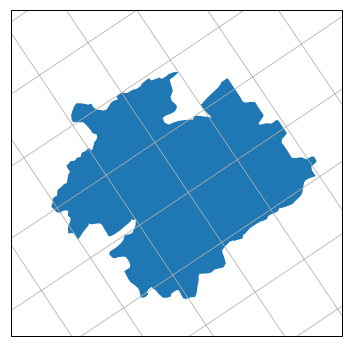

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 1687
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[78.15379176547472, 17.552665220579843], [78.16734375580529, 17.552859679408396], [78.16714143788593, 17.565859911723514], [78.15358848280565, 17.56566529977946], [78.15379176547472, 17.552665220579843]]]}


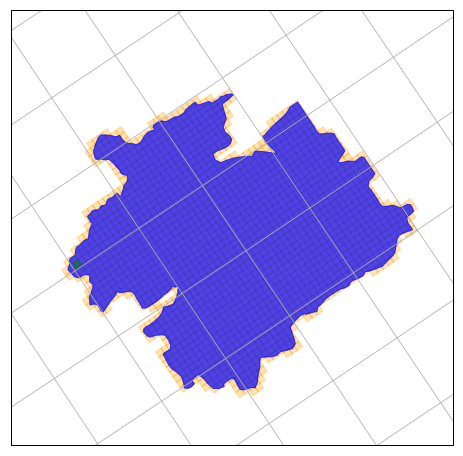

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Set input stack and model parameters

In [5]:
window = 17    # width of square window

bands_vir=bands[:-1]
bands_sar=None
bands_ndvi=ndvi_bands
bands_ndbi=None
bands_osm=None

haze_removal = False

image_suffix = 'V'

model_id = 'Roads_Hyd_P-U'
unflatten_input = True # is the model a cnn?
n_cats = 2 # number of categories

water_overwrite = False
water_mask = True

In [6]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+ndvi 7


### Use model to generate performance statistics
This can be skipped if desired

Assign application-specific variables

In [7]:
cats_map = {}
cats_map[0] = 0
cats_map[1] = 1
cats_map[2] = 4
cats_map[3] = 4
cats_map[4] = 4
cats_map[5] = 4
cats_map[6] = 6

categories = [0,1,4,6]

notes = 'application of Roads_Hyd_P-U to an out of sample image (Hyderabad_V)'

Load the samples of interest. Just as when training a model, this dataset can be constructed from one or more images of one or more cities.

In [8]:
place_images = {}
place_images[place] = ['V']

X_train_raw, Y_train_raw, X_valid_raw, Y_valid_raw = util_workflow.load_datasets(place_images, data_root, label_suffix, stack_label, window, resolution=resolution)

calculate total size of training and validation supersets
/data/phase_iii/hyderabad/hyderabad_train_aue-roads_5m_vir+ndvi_17w_V.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue-roads_5m_vir+ndvi_17w_V.pkl
(225975, 2023) (225975,) (96847, 2023) (96847,)
225975 96847
construct np arrays for supersets
populate superset np arrays
/data/phase_iii/hyderabad/hyderabad_train_aue-roads_5m_vir+ndvi_17w_V.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue-roads_5m_vir+ndvi_17w_V.pkl
(225975, 2023) (225975,) (96847, 2023) (96847,)
(225975, 2023) (225975,)


Prepare data for model ingestion. This process is contingent on what model is being applied and what taxonomy that model employs.

In [9]:
X_train_raw_scaled, X_valid_raw_scaled, scaler = util_ml.scale_learning_data(X_train_raw, X_valid_raw)
print X_train_raw_scaled.shape,  X_valid_raw_scaled.shape

(225975, 2023) (96847, 2023)
(225975, 2023) (96847, 2023)


In [10]:
del X_train_raw, X_valid_raw

In [11]:
# Don't run this if using DNN
X_train = X_train_raw_scaled.reshape((X_train_raw_scaled.shape[0],feature_count,window,window))
X_valid = X_valid_raw_scaled.reshape((X_valid_raw_scaled.shape[0],feature_count,window,window))

In [12]:
del X_train_raw_scaled, X_valid_raw_scaled

In [13]:
Y_train = Y_train_raw.copy()
Y_valid = Y_valid_raw.copy()

for k, v in cats_map.items():
    Y_train[Y_train_raw==k] = v
    Y_valid[Y_valid_raw==k] = v

### Convert to binary category

In [14]:
NB_FILTERS_1=32
NB_FILTERS_2=64

cats=[0,1]
networks = []
# for cat in [6,4,1,0]:
for cat in [6]:
    print 'category:', str(cat)
    
    # create binary data
    Y_t_bin = util_ml.make_binary(Y_train, cat, silent=True)
    Y_v_bin = util_ml.make_binary(Y_valid, cat, silent=True)
        
    #balance
    X_t_balanced, Y_t_balanced = util_ml.balance_binary(X_train, Y_t_bin, max_ratio=2.5, silent=False)    

category: 6
min: 60471 ; max: 165504
(211648, 7, 17, 17)
151177 60471
(211648,)
[1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0]


In [15]:
weights = util_ml.generate_category_weights_simple(Y_t_balanced)
print 'weights', weights

# loss = util_ml.weighted_categorical_crossentropy(weights)


        0      1
0  151177  60471
weights [1.0, 2.4999917315738123]


### Load model objects

In [16]:
scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
#model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
network_filename = data_root+'models/'+model_id+'.hd5'

with open(scaler_filename, "rb") as f:
    scaler = pickle.load(f)
f.close()

network = load_model(network_filename)

In [17]:
# score model
print "evaluate training"
Yhat_t_prob = network.predict(X_t_balanced)
Yhat_t = np.rint(Yhat_t_prob).astype(int).reshape(Yhat_t_prob.shape[0])
# print Yhat_t_prob[0:20]
# print Yhat_t[0:20]
#Yhat_t = Yhat_t_prob.argmax(axis=-1)
train_confusion = util_ml.calc_confusion(Yhat_t,Y_t_balanced,cats)
train_recalls, train_precisions, train_accuracy = util_ml.calc_confusion_details(train_confusion)
print train_recalls, train_precisions
print

print "evaluate validation"
Yhat_v_prob = network.predict(X_valid)
Yhat_v = np.rint(Yhat_v_prob).astype(int).reshape(Yhat_v_prob.shape[0])
# print Yhat_v_prob[0:20]
# print Yhat_v[0:20]
#Yhat_v = Yhat_v_prob.argmax(axis=-1)
valid_confusion = util_ml.calc_confusion(Yhat_v,Y_v_bin,cats)
valid_recalls, valid_precisions, valid_accuracy = util_ml.calc_confusion_details(valid_confusion)
print valid_recalls, valid_precisions
print
    

evaluate training
0 151177
1 60471
[[139139  12038]
 [ 15487  44984]]
211648 184123 0.8699491608708799
[0.9203715  0.74389374] [0.8998422 0.7888885]

evaluate validation
0 70871
1 25976
[[64182  6689]
 [ 8009 17967]]
96847 82149 0.8482348446518736
[0.90561724 0.6916769 ] [0.8890582 0.728707 ]



In [18]:
# Calculate f-score
beta = 2
train_f_score = (beta**2 + 1) * train_precisions * train_recalls / ( (beta**2 * train_precisions) + train_recalls )
train_f_score_open = None#train_f_score[0] 
train_f_score_nonres = None#train_f_score[1]  
train_f_score_res = None#train_f_score[2]  
train_f_score_roads = None#train_f_score[3]  
train_f_score_average = np.mean(train_f_score)

# Calculate f-score
valid_f_score = (beta**2 + 1) * valid_precisions * valid_recalls / ( (beta**2 * valid_precisions) + valid_recalls )
valid_f_score_open = None#valid_f_score[0] 
valid_f_score_nonres = None#valid_f_score[1] 
valid_f_score_res = None#valid_f_score[2] 
valid_f_score_roads = None# valid_f_score[3] 
valid_f_score_average = np.mean(valid_f_score)

# expanding lists to match expected model_record stuff
train_recalls_expanded = [train_recalls[0],None,None,train_recalls[1]]
valid_recalls_expanded = [valid_recalls[0],None,None,valid_recalls[1]]
train_precisions_expanded = [train_precisions[0],None,None,train_precisions[1]]
valid_precisions_expanded = [valid_precisions[0],None,None,valid_precisions[1]]

util_workflow.record_model_application(
        model_id, notes, place_images, label_suffix, resolution, stack_label, feature_count, window, cats_map, 
        train_confusion, train_recalls_expanded, train_precisions_expanded, train_accuracy,
        train_f_score_open, train_f_score_nonres, train_f_score_res, train_f_score_roads, train_f_score_average,
        valid_confusion, valid_recalls_expanded, valid_precisions_expanded, valid_accuracy,
        valid_f_score_open, valid_f_score_nonres, valid_f_score_res, valid_f_score_roads, valid_f_score_average,)

### Use model to generate comprehensive LULC raster

In [19]:
reload(util_workflow)

util_workflow.classify_tiles(data_path, place, tiles, image_suffix,
        window, stack_label, feature_count, model_id, scaler, network, n_cats,
        bands_vir=bands_vir,
        bands_sar=bands_sar, bands_ndvi=bands_ndvi, bands_ndbi=bands_ndbi, bands_osm=None,
        haze_removal=False, unflatten_input=unflatten_input, water_overwrite=water_overwrite, water_mask=water_mask)

Feature count: 7
Stack label:  vir+ndvi
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [195280.0, 1934000.0, 196720.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-238:1511', u'ti': -238, u'tj': 1511, u'geotrans': [195280.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32644"]]'}
tile 0 load VIR im

vir shape: (7, 288, 288)
17924 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.3706 )
vir band 1 into imn band 1 ( 0.0 - 0.4389 )
vir band 2 into imn band 2 ( 0.0 - 0.5024 )
vir band 3 into imn band 3 ( 0.0 - 0.568 )
vir band 4 into imn band 4 ( 0.0 - 0.6413 )
vir band 5 into imn band 5 ( 0.0 - 0.512 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.036915474 - 0.60965466 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65103
1 433
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0004_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 4 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0004_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0004_water_V.tif
tile 4 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u

vir shape: (7, 288, 288)
31776 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1697 )
vir band 1 into imn band 1 ( 0.0 - 0.1738 )
vir band 2 into imn band 2 ( 0.0 - 0.2003 )
vir band 3 into imn band 3 ( 0.0 - 0.289 )
vir band 4 into imn band 4 ( 0.0 - 0.335 )
vir band 5 into imn band 5 ( 0.0 - 0.2496 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.020100405 - 0.51071477 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64962
1 574
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0009_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.6743714e-07 3.6743714e-07 0.0000000e+00 0.0000000e+00]
tile 9 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0009_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0009_water_V.tif
tile 9 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u

vir shape: (7, 288, 288)
79716 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1967 )
vir band 1 into imn band 1 ( 0.0 - 0.1919 )
vir band 2 into imn band 2 ( 0.0 - 0.223 )
vir band 3 into imn band 3 ( 0.0 - 0.2693 )
vir band 4 into imn band 4 ( 0.0 - 0.4045 )
vir band 5 into imn band 5 ( 0.0 - 0.3955 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.0056497077 - 0.49840295 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63879
1 1657
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0014_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00033954 0.00033954 0.         0.        ]
tile 14 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0014_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0014_water_V.tif
tile 14 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'output

tile 18 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [197840.0, 1939120.0, 199280.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-236:1515', u'ti': -236, u'tj': 1515, u'geotrans': [197840.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32644"]]'}
tile 19 load VIR image
/data/phase_iii/hydera

.....................done
0 63686
1 1850
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0023_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.91991e-07 3.91991e-07 0.00000e+00 0.00000e+00]
tile 23 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0023_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0023_water_V.tif
tile 23 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [199120.0, 1932720.0, 200560.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-235:1510', u'ti': -235, u'tj': 1510, u'geotrans': [199120.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.118 - 0.2099 )
vir band 1 into imn band 1 ( 0.0987 - 0.2106 )
vir band 2 into imn band 2 ( 0.0789 - 0.2539 )
vir band 3 into imn band 3 ( 0.1032 - 0.3503 )
vir band 4 into imn band 4 ( 0.0355 - 0.3697 )
vir band 5 into imn band 5 ( 0.0208 - 0.3182 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.04072774 - 0.6185838 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64946
1 590
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0028_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [6.116573e-09 6.116573e-09 0.000000e+00 0.000000e+00]
tile 28 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0028_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0028_water_V.tif
tile 28 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u

vir shape: (7, 288, 288)
81194 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1833 )
vir band 1 into imn band 1 ( 0.0 - 0.1712 )
vir band 2 into imn band 2 ( 0.0 - 0.1919 )
vir band 3 into imn band 3 ( 0.0 - 0.3382 )
vir band 4 into imn band 4 ( 0.0 - 0.3449 )
vir band 5 into imn band 5 ( 0.0 - 0.245 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0 - 0.56176275 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65254
1 282
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0033_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.9835176e-08 4.9835176e-08 0.0000000e+00 0.0000000e+00]
tile 33 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0033_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0033_water_V.tif
tile 33 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outpu

/data/phase_iii/hyderabad/hyderabad_tile0038_vir_V_5m.tif
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.124 - 0.1835 )
vir band 1 into imn band 1 ( 0.1036 - 0.1688 )
vir band 2 into imn band 2 ( 0.0844 - 0.2064 )
vir band 3 into imn band 3 ( 0.1056 - 0.302 )
vir band 4 into imn band 4 ( 0.0455 - 0.4008 )
vir band 5 into imn band 5 ( 0.0241 - 0.3266 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.051496778 - 0.55509424 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64872
1 664
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0038_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00805981 0.00805981 0.         0.        ]
tile 38 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0038_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0038_water_V.tif
tile 38 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_d

.....................done
0 63071
1 2465
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0042_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.657619 0.657619 1.       1.      ]
tile 42 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0042_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0042_water_V.tif
tile 42 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [200400.0, 1942960.0, 201840.0, 1944400.0], u'pad': 16, u'key': u'256:16:5.0:44:-234:1518', u'ti': -234, u'tj': 1518, u'geotrans': [200400.0, 5.0, 0, 1944400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION[

vir shape: (7, 288, 288)
14847 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1927 )
vir band 1 into imn band 1 ( 0.0 - 0.1965 )
vir band 2 into imn band 2 ( 0.0 - 0.2272 )
vir band 3 into imn band 3 ( 0.0 - 0.3651 )
vir band 4 into imn band 4 ( 0.0 - 0.4372 )
vir band 5 into imn band 5 ( 0.0 - 0.2997 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.17150591 - 0.6267446 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65404
1 132
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0047_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 47 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0047_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0047_water_V.tif
tile 47 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644',

vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0051_water_V.tif
tile 51 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [201680.0, 1916080.0, 203120.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-233:1497', u'ti': -233, u'tj': 1497, u'geotrans': [201680.0, 5.0, 0, 1917520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Nort

.....................done
0 65384
1 152
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0056_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 56 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0056_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0056_water_V.tif
tile 56 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [201680.0, 1932720.0, 203120.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-233:1510', u'ti': -233, u'tj': 1510, u'geotrans': [201680.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1187 - 0.2249 )
vir band 1 into imn band 1 ( 0.0984 - 0.2352 )
vir band 2 into imn band 2 ( 0.0821 - 0.2771 )
vir band 3 into imn band 3 ( 0.1016 - 0.349 )
vir band 4 into imn band 4 ( 0.0374 - 0.3592 )
vir band 5 into imn band 5 ( 0.0212 - 0.3126 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.027291138 - 0.5597957 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64564
1 972
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0061_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.5796731e-08 1.5796731e-08 0.0000000e+00 0.0000000e+00]
tile 61 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0061_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0061_water_V.tif
tile 61 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_cod

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1232 - 0.2415 )
vir band 1 into imn band 1 ( 0.0988 - 0.2495 )
vir band 2 into imn band 2 ( 0.0822 - 0.2917 )
vir band 3 into imn band 3 ( 0.0645 - 0.3217 )
vir band 4 into imn band 4 ( 0.034 - 0.4319 )
vir band 5 into imn band 5 ( 0.0192 - 0.4021 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.13597994 - 0.4313888 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61782
1 3754
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0066_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.53979623 0.53979623 1.         1.        ]
tile 66 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0066_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0066_water_V.tif
tile 66 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:3

.....................done
0 65280
1 256
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0071_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [6.554484e-16 6.554484e-16 0.000000e+00 0.000000e+00]
tile 71 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0071_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0071_water_V.tif
tile 71 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [202960.0, 1912240.0, 204400.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-232:1494', u'ti': -232, u'tj': 1494, u'geotrans': [202960.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326

nz 65536
.....................done
0 65370
1 166
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0076_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 76 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0076_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0076_water_V.tif
tile 76 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [202960.0, 1921200.0, 204400.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-232:1501', u'ti': -232, u'tj': 1501, u'geotrans': [202960.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY

vir shape: (7, 288, 288)
66759 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2005 )
vir band 1 into imn band 1 ( 0.0 - 0.2116 )
vir band 2 into imn band 2 ( 0.0 - 0.2583 )
vir band 3 into imn band 3 ( 0.0 - 0.3049 )
vir band 4 into imn band 4 ( 0.0 - 0.4025 )
vir band 5 into imn band 5 ( 0.0 - 0.349 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.105554976 - 0.42287907 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65157
1 379
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0081_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01426697 0.01426697 0.         0.        ]
tile 81 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0081_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0081_water_V.tif
tile 81 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBo

82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1161 - 0.1692 )
vir band 1 into imn band 1 ( 0.0943 - 0.165 )
vir band 2 into imn band 2 ( 0.0789 - 0.2063 )
vir band 3 into imn band 3 ( 0.0801 - 0.3102 )
vir band 4 into imn band 4 ( 0.0514 - 0.3817 )
vir band 5 into imn band 5 ( 0.0287 - 0.3192 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.18786478 - 0.52450234 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65187
1 349
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0086_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [5.3190456e-07 5.3190456e-07 0.0000000e+00 0.0000000e+00]
tile 86 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0086_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0086_water_V.tif
tile 86 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outp

/data/phase_iii/hyderabad/maps/hyderabad_tile0090_water_V.tif
tile 90 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [202960.0, 1945520.0, 204400.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-232:1520', u'ti': -232, u'tj': 1520, u'geotrans': [202960.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["E

.....................done
0 65092
1 444
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0095_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00036362 0.00036362 0.         0.        ]
tile 95 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0095_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0095_water_V.tif
tile 95 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1912240.0, 205680.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1494', u'ti': -231, u'tj': 1494, u'geotrans': [204240.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJ

vir shape: (7, 288, 288)
52685 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1724 )
vir band 1 into imn band 1 ( 0.0 - 0.172 )
vir band 2 into imn band 2 ( 0.0 - 0.2085 )
vir band 3 into imn band 3 ( 0.0 - 0.3389 )
vir band 4 into imn band 4 ( 0.0 - 0.3358 )
vir band 5 into imn band 5 ( 0.0 - 0.2225 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.053971216 - 0.5684276 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65157
1 379
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0100_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 100 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0100_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0100_water_V.tif
tile 100 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644

.....................done
0 65382
1 154
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0105_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 105 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0105_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0105_water_V.tif
tile 105 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1927600.0, 205680.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1506', u'ti': -231, u'tj': 1506, u'geotrans': [204240.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 62324
1 3212
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0110_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.6608483e-08 3.6608483e-08 0.0000000e+00 0.0000000e+00]
tile 110 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0110_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0110_water_V.tif
tile 110 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1934000.0, 205680.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1511', u'ti': -231, u'tj': 1511, u'geotrans': [204240.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 65057
1 479
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0115_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00035177 0.00035177 0.         0.        ]
tile 115 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0115_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0115_water_V.tif
tile 115 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1940400.0, 205680.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1516', u'ti': -231, u'tj': 1516, u'geotrans': [204240.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1144 - 0.1663 )
vir band 1 into imn band 1 ( 0.0933 - 0.1669 )
vir band 2 into imn band 2 ( 0.0753 - 0.2182 )
vir band 3 into imn band 3 ( 0.0764 - 0.294 )
vir band 4 into imn band 4 ( 0.0304 - 0.4117 )
vir band 5 into imn band 5 ( 0.0177 - 0.271 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.026751447 - 0.5634124 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65138
1 398
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0120_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [7.044627e-06 7.044627e-06 0.000000e+00 0.000000e+00]
tile 120 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0120_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0120_water_V.tif
tile 120 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code':

vir shape: (7, 288, 288)
23934 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2197 )
vir band 1 into imn band 1 ( 0.0 - 0.2391 )
vir band 2 into imn band 2 ( 0.0 - 0.2684 )
vir band 3 into imn band 3 ( 0.0 - 0.3531 )
vir band 4 into imn band 4 ( 0.0 - 0.4086 )
vir band 5 into imn band 5 ( 0.0 - 0.4861 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.11052849 - 0.586648 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65242
1 294
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0125_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 125 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0125_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0125_water_V.tif
tile 125 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1116 - 0.2047 )
vir band 1 into imn band 1 ( 0.0907 - 0.2199 )
vir band 2 into imn band 2 ( 0.0715 - 0.2482 )
vir band 3 into imn band 3 ( 0.0929 - 0.4358 )
vir band 4 into imn band 4 ( 0.1228 - 0.3556 )
vir band 5 into imn band 5 ( 0.063 - 0.231 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.040519726 - 0.718114 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64658
1 878
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0130_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [5.4342236e-06 5.4342236e-06 0.0000000e+00 0.0000000e+00]
tile 130 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0130_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0130_water_V.tif
tile 130 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_cod

.....................done
0 65503
1 33
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0134_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.08593285e-05 1.08593285e-05 0.00000000e+00 0.00000000e+00]
tile 134 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0134_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0134_water_V.tif
tile 134 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1921200.0, 206960.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1501', u'ti': -230, u'tj': 1501, u'geotrans': [205520.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

.....................done
0 65103
1 433
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0139_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.77831e-06 2.77831e-06 0.00000e+00 0.00000e+00]
tile 139 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0139_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0139_water_V.tif
tile 139 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1928880.0, 206960.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1507', u'ti': -230, u'tj': 1507, u'geotrans': [205520.0, 5.0, 0, 1930320.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 63991
1 1545
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0144_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00521501 0.00521501 0.         0.        ]
tile 144 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0144_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0144_water_V.tif
tile 144 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1935280.0, 206960.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1512', u'ti': -230, u'tj': 1512, u'geotrans': [205520.0, 5.0, 0, 1936720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1202 - 0.2228 )
vir band 1 into imn band 1 ( 0.0983 - 0.2286 )
vir band 2 into imn band 2 ( 0.0748 - 0.2764 )
vir band 3 into imn band 3 ( 0.0736 - 0.3473 )
vir band 4 into imn band 4 ( 0.0373 - 0.3433 )
vir band 5 into imn band 5 ( 0.0202 - 0.2933 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.03094119 - 0.5844734 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 60823
1 4713
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0149_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.0001295 0.0001295 0.        0.       ]
tile 149 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0149_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0149_water_V.tif
tile 149 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32

.....................done
0 65417
1 119
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0154_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [7.4862265e-16 7.4862265e-16 0.0000000e+00 0.0000000e+00]
tile 154 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0154_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0154_water_V.tif
tile 154 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1948080.0, 206960.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1522', u'ti': -230, u'tj': 1522, u'geotrans': [205520.0, 5.0, 0, 1949520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

vir shape: (7, 288, 288)
70073 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1907 )
vir band 1 into imn band 1 ( 0.0 - 0.1983 )
vir band 2 into imn band 2 ( 0.0 - 0.2331 )
vir band 3 into imn band 3 ( 0.0 - 0.3638 )
vir band 4 into imn band 4 ( 0.0 - 0.4403 )
vir band 5 into imn band 5 ( 0.0 - 0.3419 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.221706 - 0.6155205 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65122
1 414
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0159_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.9778745e-08 4.9778745e-08 0.0000000e+00 0.0000000e+00]
tile 159 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0159_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0159_water_V.tif
tile 159 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644',

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1119 - 0.2031 )
vir band 1 into imn band 1 ( 0.0942 - 0.2029 )
vir band 2 into imn band 2 ( 0.074 - 0.2337 )
vir band 3 into imn band 3 ( 0.1269 - 0.4286 )
vir band 4 into imn band 4 ( 0.1113 - 0.3722 )
vir band 5 into imn band 5 ( 0.0725 - 0.2759 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.009496408 - 0.7051905 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65392
1 144
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0164_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [7.772309e-06 7.772309e-06 0.000000e+00 0.000000e+00]
tile 164 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0164_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0164_water_V.tif
tile 164 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code':

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1111 - 0.1667 )
vir band 1 into imn band 1 ( 0.0904 - 0.1731 )
vir band 2 into imn band 2 ( 0.0726 - 0.2101 )
vir band 3 into imn band 3 ( 0.0899 - 0.3861 )
vir band 4 into imn band 4 ( 0.0297 - 0.3816 )
vir band 5 into imn band 5 ( 0.0151 - 0.2851 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.0034158635 - 0.6429773 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64764
1 772
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0169_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0. 0. 0. 0.]
tile 169 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0169_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0169_water_V.tif
tile 169 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206

.....................done
0 65446
1 90
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0174_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 174 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0174_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0174_water_V.tif
tile 174 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206800.0, 1926320.0, 208240.0, 1927760.0], u'pad': 16, u'key': u'256:16:5.0:44:-229:1505', u'ti': -229, u'tj': 1505, u'geotrans': [206800.0, 5.0, 0, 1927760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1183 - 0.243 )
vir band 1 into imn band 1 ( 0.1 - 0.2517 )
vir band 2 into imn band 2 ( 0.0819 - 0.2864 )
vir band 3 into imn band 3 ( 0.0771 - 0.3132 )
vir band 4 into imn band 4 ( 0.033 - 0.3519 )
vir band 5 into imn band 5 ( 0.0204 - 0.281 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.15181433 - 0.5172758 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63803
1 1733
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0179_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00222394 0.00222394 0.         0.        ]
tile 179 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0179_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0179_water_V.tif
tile 179 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:3264

.....................done
0 63997
1 1539
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0184_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.7997782e-19 1.7997782e-19 0.0000000e+00 0.0000000e+00]
tile 184 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0184_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0184_water_V.tif
tile 184 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206800.0, 1939120.0, 208240.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-229:1515', u'ti': -229, u'tj': 1515, u'geotrans': [206800.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 64580
1 956
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0189_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [8.5486754e-05 8.5486754e-05 0.0000000e+00 0.0000000e+00]
tile 189 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0189_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0189_water_V.tif
tile 189 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206800.0, 1945520.0, 208240.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-229:1520', u'ti': -229, u'tj': 1520, u'geotrans': [206800.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

nz 65536
.....................done
0 65282
1 254
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0194_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 194 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0194_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0194_water_V.tif
tile 194 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1904560.0, 209520.0, 1906000.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1488', u'ti': -228, u'tj': 1488, u'geotrans': [208080.0, 5.0, 0, 1906000.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORI

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1115 - 0.2104 )
vir band 1 into imn band 1 ( 0.0965 - 0.2124 )
vir band 2 into imn band 2 ( 0.0722 - 0.245 )
vir band 3 into imn band 3 ( 0.064 - 0.3945 )
vir band 4 into imn band 4 ( 0.0413 - 0.4467 )
vir band 5 into imn band 5 ( 0.021 - 0.6213 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.108547404 - 0.62613225 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65085
1 451
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0199_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00184561 0.00184561 0.         0.        ]
tile 199 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0199_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0199_water_V.tif
tile 199 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:

.....................done
0 65454
1 82
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0203_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.05684351 0.05684351 0.         0.        ]
tile 203 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0203_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0203_water_V.tif
tile 203 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1916080.0, 209520.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1497', u'ti': -228, u'tj': 1497, u'geotrans': [208080.0, 5.0, 0, 1917520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PRO

ndvi raw into imn band 6 ( 0.07097827 - 0.60475945 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65421
1 115
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0208_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00015788 0.00015788 0.         0.        ]
tile 208 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0208_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0208_water_V.tif
tile 208 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1922480.0, 209520.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1502', u'ti': -228, u'tj': 1502, u'geotrans': [208080.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["

.....................done
0 64983
1 553
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0213_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00197842 0.00197842 0.         0.        ]
tile 213 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0213_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0213_water_V.tif
tile 213 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1930160.0, 209520.0, 1931600.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1508', u'ti': -228, u'tj': 1508, u'geotrans': [208080.0, 5.0, 0, 1931600.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1109 - 0.1597 )
vir band 1 into imn band 1 ( 0.0871 - 0.1624 )
vir band 2 into imn band 2 ( 0.0645 - 0.1856 )
vir band 3 into imn band 3 ( 0.051 - 0.314 )
vir band 4 into imn band 4 ( 0.0161 - 0.312 )
vir band 5 into imn band 5 ( 0.0061 - 0.212 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.13996509 - 0.61566466 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64552
1 984
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0218_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00018255 0.00018255 0.         0.        ]
tile 218 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0218_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0218_water_V.tif
tile 218 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32

.....................done
0 60420
1 5116
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0222_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01257836 0.01257836 0.         0.        ]
tile 222 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0222_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0222_water_V.tif
tile 222 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1941680.0, 209520.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1517', u'ti': -228, u'tj': 1517, u'geotrans': [208080.0, 5.0, 0, 1943120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 64664
1 872
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0227_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02111309 0.02111309 0.         0.        ]
tile 227 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0227_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0227_water_V.tif
tile 227 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1948080.0, 209520.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1522', u'ti': -228, u'tj': 1522, u'geotrans': [208080.0, 5.0, 0, 1949520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1092 - 0.1733 )
vir band 1 into imn band 1 ( 0.0911 - 0.1673 )
vir band 2 into imn band 2 ( 0.0758 - 0.2114 )
vir band 3 into imn band 3 ( 0.0785 - 0.3805 )
vir band 4 into imn band 4 ( 0.0266 - 0.4143 )
vir band 5 into imn band 5 ( 0.0138 - 0.2993 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.275829 - 0.6248005 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65272
1 264
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0232_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.8778157e-23 4.8778157e-23 0.0000000e+00 0.0000000e+00]
tile 232 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0232_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0232_water_V.tif
tile 232 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_cod

.....................done
0 65198
1 338
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0236_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02723134 0.02723134 0.         0.        ]
tile 236 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0236_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0236_water_V.tif
tile 236 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1912240.0, 210800.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1494', u'ti': -227, u'tj': 1494, u'geotrans': [209360.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

.....................done
0 63928
1 1608
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0241_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02845622 0.02845622 0.         0.        ]
tile 241 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0241_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0241_water_V.tif
tile 241 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1918640.0, 210800.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1499', u'ti': -227, u'tj': 1499, u'geotrans': [209360.0, 5.0, 0, 1920080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 64894
1 642
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0246_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00577673 0.00577673 0.         0.        ]
tile 246 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0246_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0246_water_V.tif
tile 246 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1925040.0, 210800.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1504', u'ti': -227, u'tj': 1504, u'geotrans': [209360.0, 5.0, 0, 1926480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1188 - 0.2376 )
vir band 1 into imn band 1 ( 0.1004 - 0.2451 )
vir band 2 into imn band 2 ( 0.0804 - 0.285 )
vir band 3 into imn band 3 ( 0.0999 - 0.3576 )
vir band 4 into imn band 4 ( 0.039 - 0.3829 )
vir band 5 into imn band 5 ( 0.0237 - 0.3257 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.04702665 - 0.6169523 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64901
1 635
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0251_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.13014552 0.13014552 0.         0.        ]
tile 251 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0251_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0251_water_V.tif
tile 251 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:3

.....................done
0 63856
1 1680
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0256_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.9719931e-07 1.9719931e-07 0.0000000e+00 0.0000000e+00]
tile 256 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0256_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0256_water_V.tif
tile 256 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1939120.0, 210800.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1515', u'ti': -227, u'tj': 1515, u'geotrans': [209360.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 64208
1 1328
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0261_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.5999127e-35 1.5999127e-35 0.0000000e+00 0.0000000e+00]
tile 261 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0261_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0261_water_V.tif
tile 261 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1945520.0, 210800.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1520', u'ti': -227, u'tj': 1520, u'geotrans': [209360.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 65339
1 197
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0266_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 266 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0266_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0266_water_V.tif
tile 266 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1900720.0, 212080.0, 1902160.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1485', u'ti': -226, u'tj': 1485, u'geotrans': [210640.0, 5.0, 0, 1902160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 65050
1 486
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0271_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.03904e-14 2.03904e-14 0.00000e+00 0.00000e+00]
tile 271 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0271_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0271_water_V.tif
tile 271 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1907120.0, 212080.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1490', u'ti': -226, u'tj': 1490, u'geotrans': [210640.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1145 - 0.1791 )
vir band 1 into imn band 1 ( 0.0938 - 0.186 )
vir band 2 into imn band 2 ( 0.0746 - 0.235 )
vir band 3 into imn band 3 ( 0.1335 - 0.3868 )
vir band 4 into imn band 4 ( 0.0839 - 0.4369 )
vir band 5 into imn band 5 ( 0.049 - 0.3522 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.041481342 - 0.63856846 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65065
1 471
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0276_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.3080356 0.3080356 0.        0.       ]
tile 276 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0276_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0276_water_V.tif
tile 276 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644

.....................done
0 64482
1 1054
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0280_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.595948e-05 3.595948e-05 0.000000e+00 0.000000e+00]
tile 280 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0280_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0280_water_V.tif
tile 280 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1918640.0, 212080.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1499', u'ti': -226, u'tj': 1499, u'geotrans': [210640.0, 5.0, 0, 1920080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 65021
1 515
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0285_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0. 0. 0. 0.]
tile 285 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0285_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0285_water_V.tif
tile 285 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1925040.0, 212080.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1504', u'ti': -226, u'tj': 1504, u'geotrans': [210640.0, 5.0, 0, 1926480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],

.....................done
0 62997
1 2539
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0290_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.0740845e-26 4.0740845e-26 0.0000000e+00 0.0000000e+00]
tile 290 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0290_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0290_water_V.tif
tile 290 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1932720.0, 212080.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1510', u'ti': -226, u'tj': 1510, u'geotrans': [210640.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1223 - 0.2362 )
vir band 1 into imn band 1 ( 0.1019 - 0.2403 )
vir band 2 into imn band 2 ( 0.0859 - 0.2698 )
vir band 3 into imn band 3 ( 0.0773 - 0.2941 )
vir band 4 into imn band 4 ( 0.0872 - 0.3775 )
vir band 5 into imn band 5 ( 0.0461 - 0.3052 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.10011584 - 0.48687604 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 59393
1 6143
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0295_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.4817878e-05 1.4817878e-05 0.0000000e+00 0.0000000e+00]
tile 295 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0295_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0295_water_V.tif
tile 295 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs

.....................done
0 64253
1 1283
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0299_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0. 0. 0. 0.]
tile 299 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0299_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0299_water_V.tif
tile 299 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1944240.0, 212080.0, 1945680.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1519', u'ti': -226, u'tj': 1519, u'geotrans': [210640.0, 5.0, 0, 1945680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"]

.....................done
0 64953
1 583
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0304_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3702904e-11 2.3702904e-11 0.0000000e+00 0.0000000e+00]
tile 304 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0304_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0304_water_V.tif
tile 304 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1950640.0, 212080.0, 1952080.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1524', u'ti': -226, u'tj': 1524, u'geotrans': [210640.0, 5.0, 0, 1952080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 65303
1 233
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0309_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.693729e-08 2.693729e-08 0.000000e+00 0.000000e+00]
tile 309 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0309_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0309_water_V.tif
tile 309 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1905840.0, 213360.0, 1907280.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1489', u'ti': -225, u'tj': 1489, u'geotrans': [211920.0, 5.0, 0, 1907280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","43

.....................done
0 63768
1 1768
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0314_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.32732165 0.32732165 0.         0.        ]
tile 314 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0314_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0314_water_V.tif
tile 314 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1912240.0, 213360.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1494', u'ti': -225, u'tj': 1494, u'geotrans': [211920.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1153 - 0.2263 )
vir band 1 into imn band 1 ( 0.0956 - 0.2347 )
vir band 2 into imn band 2 ( 0.0789 - 0.2664 )
vir band 3 into imn band 3 ( 0.1068 - 0.3439 )
vir band 4 into imn band 4 ( 0.0711 - 0.4595 )
vir band 5 into imn band 5 ( 0.048 - 0.3664 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0 - 0.5111955 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64502
1 1034
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0319_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.586726e-08 4.586726e-08 0.000000e+00 0.000000e+00]
tile 319 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0319_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0319_water_V.tif
tile 319 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG

.....................done
0 65450
1 86
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0324_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.7302363e-35 2.7302363e-35 0.0000000e+00 0.0000000e+00]
tile 324 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0324_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0324_water_V.tif
tile 324 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1925040.0, 213360.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1504', u'ti': -225, u'tj': 1504, u'geotrans': [211920.0, 5.0, 0, 1926480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

.....................done
0 64792
1 744
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0329_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02335214 0.02335214 0.         0.        ]
tile 329 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0329_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0329_water_V.tif
tile 329 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1931440.0, 213360.0, 1932880.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1509', u'ti': -225, u'tj': 1509, u'geotrans': [211920.0, 5.0, 0, 1932880.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

.....................done
0 61090
1 4446
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0334_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.47393122 0.47393122 0.         0.        ]
tile 334 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0334_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0334_water_V.tif
tile 334 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1937840.0, 213360.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1514', u'ti': -225, u'tj': 1514, u'geotrans': [211920.0, 5.0, 0, 1939280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 63557
1 1979
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0339_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00925578 0.00925578 0.         0.        ]
tile 339 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0339_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0339_water_V.tif
tile 339 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1944240.0, 213360.0, 1945680.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1519', u'ti': -225, u'tj': 1519, u'geotrans': [211920.0, 5.0, 0, 1945680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 65181
1 355
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0344_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.213387e-10 2.213387e-10 0.000000e+00 0.000000e+00]
tile 344 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0344_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0344_water_V.tif
tile 344 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1950640.0, 213360.0, 1952080.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1524', u'ti': -225, u'tj': 1524, u'geotrans': [211920.0, 5.0, 0, 1952080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","43

.....................done
0 65334
1 202
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0349_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.0756588e-05 2.0756588e-05 0.0000000e+00 0.0000000e+00]
tile 349 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0349_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0349_water_V.tif
tile 349 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1904560.0, 214640.0, 1906000.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1488', u'ti': -224, u'tj': 1488, u'geotrans': [213200.0, 5.0, 0, 1906000.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

nz 65536
.....................done
0 65277
1 259
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0354_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.797669e-07 4.797669e-07 0.000000e+00 0.000000e+00]
tile 354 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0354_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0354_water_V.tif
tile 354 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1910960.0, 214640.0, 1912400.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1493', u'ti': -224, u'tj': 1493, u'geotrans': [213200.0, 5.0, 0, 1912400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["

.....................done
0 65233
1 303
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0359_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.9855738e-07 2.9855738e-07 0.0000000e+00 0.0000000e+00]
tile 359 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0359_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0359_water_V.tif
tile 359 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1917360.0, 214640.0, 1918800.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1498', u'ti': -224, u'tj': 1498, u'geotrans': [213200.0, 5.0, 0, 1918800.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 65536
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0364_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0. 0. 0. 0.]
tile 364 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0364_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0364_water_V.tif
tile 364 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1923760.0, 214640.0, 1925200.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1503', u'ti': -224, u'tj': 1503, u'geotrans': [213200.0, 5.0, 0, 1925200.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAME

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1255 - 0.2169 )
vir band 1 into imn band 1 ( 0.1053 - 0.2306 )
vir band 2 into imn band 2 ( 0.0907 - 0.2758 )
vir band 3 into imn band 3 ( 0.092 - 0.3138 )
vir band 4 into imn band 4 ( 0.0355 - 0.44 )
vir band 5 into imn band 5 ( 0.0191 - 0.3521 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.21983516 - 0.38393795 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64220
1 1316
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0369_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0. 0. 0. 0.]
tile 369 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0369_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0369_water_V.tif
tile 369 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200

.....................done
0 63862
1 1674
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0374_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.16003603 0.16003603 0.         0.        ]
tile 374 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0374_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0374_water_V.tif
tile 374 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1936560.0, 214640.0, 1938000.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1513', u'ti': -224, u'tj': 1513, u'geotrans': [213200.0, 5.0, 0, 1938000.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 64274
1 1262
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0379_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0. 0. 0. 0.]
tile 379 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0379_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0379_water_V.tif
tile 379 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1942960.0, 214640.0, 1944400.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1518', u'ti': -224, u'tj': 1518, u'geotrans': [213200.0, 5.0, 0, 1944400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"]

.....................done
0 65243
1 293
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0384_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.7202653e-06 1.7202653e-06 0.0000000e+00 0.0000000e+00]
tile 384 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0384_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0384_water_V.tif
tile 384 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1949360.0, 214640.0, 1950800.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1523', u'ti': -224, u'tj': 1523, u'geotrans': [213200.0, 5.0, 0, 1950800.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 65535
1 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0389_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 389 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0389_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0389_water_V.tif
tile 389 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1899440.0, 215920.0, 1900880.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1484', u'ti': -223, u'tj': 1484, u'geotrans': [214480.0, 5.0, 0, 1900880.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

.....................done
0 65407
1 129
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0394_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [8.942125e-07 8.942125e-07 0.000000e+00 0.000000e+00]
tile 394 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0394_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0394_water_V.tif
tile 394 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1905840.0, 215920.0, 1907280.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1489', u'ti': -223, u'tj': 1489, u'geotrans': [214480.0, 5.0, 0, 1907280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","43

.....................done
0 64002
1 1534
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0399_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.44635755 0.44635755 0.         0.        ]
tile 399 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0399_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0399_water_V.tif
tile 399 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1912240.0, 215920.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1494', u'ti': -223, u'tj': 1494, u'geotrans': [214480.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1144 - 0.2334 )
vir band 1 into imn band 1 ( 0.092 - 0.2555 )
vir band 2 into imn band 2 ( 0.0752 - 0.3091 )
vir band 3 into imn band 3 ( 0.0943 - 0.354 )
vir band 4 into imn band 4 ( 0.0595 - 0.4336 )
vir band 5 into imn band 5 ( 0.0339 - 0.3378 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.029711628 - 0.5860347 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64973
1 563
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0404_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.5489636e-10 3.5489636e-10 0.0000000e+00 0.0000000e+00]
tile 404 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0404_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0404_water_V.tif
tile 404 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_co

imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61876
1 3660
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0409_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.003494 0.003494 0.       0.      ]
tile 409 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0409_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0409_water_V.tif
tile 409 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1925040.0, 215920.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1504', u'ti': -223, u'tj': 1504, u'geotrans': [214480.0, 5.0, 0, 1926480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORIT

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1155 - 0.2319 )
vir band 1 into imn band 1 ( 0.0911 - 0.2478 )
vir band 2 into imn band 2 ( 0.0715 - 0.2955 )
vir band 3 into imn band 3 ( 0.0652 - 0.3316 )
vir band 4 into imn band 4 ( 0.0316 - 0.4061 )
vir band 5 into imn band 5 ( 0.0188 - 0.3451 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1387275 - 0.5736398 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64558
1 978
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0414_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01636386 0.01636386 0.         0.        ]
tile 414 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0414_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0414_water_V.tif
tile 414 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:

.....................done
0 55156
1 10380
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0419_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.07862048 0.07862048 0.         0.        ]
tile 419 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0419_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0419_water_V.tif
tile 419 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1937840.0, 215920.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1514', u'ti': -223, u'tj': 1514, u'geotrans': [214480.0, 5.0, 0, 1939280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

ndvi raw into imn band 6 ( -0.17249313 - 0.463734 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64538
1 998
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0424_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02854781 0.02854781 0.         0.        ]
tile 424 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0424_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0424_water_V.tif
tile 424 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1944240.0, 215920.0, 1945680.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1519', u'ti': -223, u'tj': 1519, u'geotrans': [214480.0, 5.0, 0, 1945680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["G

.....................done
0 64956
1 580
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0429_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.3009735e-08 1.3009735e-08 0.0000000e+00 0.0000000e+00]
tile 429 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0429_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0429_water_V.tif
tile 429 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1950640.0, 215920.0, 1952080.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1524', u'ti': -223, u'tj': 1524, u'geotrans': [214480.0, 5.0, 0, 1952080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 65535
1 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0434_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 434 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0434_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0434_water_V.tif
tile 434 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1900720.0, 217200.0, 1902160.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1485', u'ti': -222, u'tj': 1485, u'geotrans': [215760.0, 5.0, 0, 1902160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

nz 65536
.....................done
0 65173
1 363
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0439_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [9.493959e-12 9.493959e-12 0.000000e+00 0.000000e+00]
tile 439 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0439_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0439_water_V.tif
tile 439 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1907120.0, 217200.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1490', u'ti': -222, u'tj': 1490, u'geotrans': [215760.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["

82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1115 - 0.1779 )
vir band 1 into imn band 1 ( 0.09 - 0.1823 )
vir band 2 into imn band 2 ( 0.0674 - 0.2215 )
vir band 3 into imn band 3 ( 0.0566 - 0.4131 )
vir band 4 into imn band 4 ( 0.0347 - 0.4268 )
vir band 5 into imn band 5 ( 0.0162 - 0.3215 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.104293644 - 0.66774184 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64427
1 1109
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0444_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00018801 0.00018801 0.         0.        ]
tile 444 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0444_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0444_water_V.tif
tile 444 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds'

vir band 5 into imn band 5 ( 0.0397 - 0.3639 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.005646157 - 0.6634785 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64046
1 1490
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0449_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.154158e-09 2.154158e-09 0.000000e+00 0.000000e+00]
tile 449 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0449_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0449_water_V.tif
tile 449 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1919920.0, 217200.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1500', u'ti': -222, u'tj': 1500, u'geotrans': [215760.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.121 - 0.2615 )
vir band 1 into imn band 1 ( 0.0995 - 0.2688 )
vir band 2 into imn band 2 ( 0.0752 - 0.3089 )
vir band 3 into imn band 3 ( 0.065 - 0.3455 )
vir band 4 into imn band 4 ( 0.0199 - 0.4233 )
vir band 5 into imn band 5 ( 0.0101 - 0.3656 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1415634 - 0.54048336 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61409
1 4127
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0454_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.546612e-06 4.546612e-06 0.000000e+00 0.000000e+00]
tile 454 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0454_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0454_water_V.tif
tile 454 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code':

.....................done
0 64600
1 936
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0459_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [8.002357e-07 8.002357e-07 0.000000e+00 0.000000e+00]
tile 459 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0459_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0459_water_V.tif
tile 459 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1932720.0, 217200.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1510', u'ti': -222, u'tj': 1510, u'geotrans': [215760.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","43

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1211 - 0.2296 )
vir band 1 into imn band 1 ( 0.1005 - 0.2647 )
vir band 2 into imn band 2 ( 0.0774 - 0.3243 )
vir band 3 into imn band 3 ( 0.0616 - 0.3751 )
vir band 4 into imn band 4 ( 0.0169 - 0.5149 )
vir band 5 into imn band 5 ( 0.0081 - 0.415 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.18947245 - 0.60739744 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64110
1 1426
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0464_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [5.474477e-07 5.474477e-07 0.000000e+00 0.000000e+00]
tile 464 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0464_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0464_water_V.tif
tile 464 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code

.....................done
0 63835
1 1701
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0468_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.6596498e-12 1.6596498e-12 0.0000000e+00 0.0000000e+00]
tile 468 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0468_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0468_water_V.tif
tile 468 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1944240.0, 217200.0, 1945680.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1519', u'ti': -222, u'tj': 1519, u'geotrans': [215760.0, 5.0, 0, 1945680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1136 - 0.2045 )
vir band 1 into imn band 1 ( 0.0946 - 0.2097 )
vir band 2 into imn band 2 ( 0.078 - 0.2345 )
vir band 3 into imn band 3 ( 0.0835 - 0.3111 )
vir band 4 into imn band 4 ( 0.0325 - 0.4237 )
vir band 5 into imn band 5 ( 0.0159 - 0.3056 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.18461451 - 0.55394465 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65164
1 372
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0473_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.21158925 0.21158925 0.         0.        ]
tile 473 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0473_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0473_water_V.tif
tile 473 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG

.....................done
0 65402
1 134
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0478_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 478 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0478_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0478_water_V.tif
tile 478 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1957040.0, 217200.0, 1958480.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1529', u'ti': -222, u'tj': 1529, u'geotrans': [215760.0, 5.0, 0, 1958480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 65477
1 59
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0483_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 483 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0483_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0483_water_V.tif
tile 483 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1902000.0, 218480.0, 1903440.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1486', u'ti': -221, u'tj': 1486, u'geotrans': [217040.0, 5.0, 0, 1903440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

.....................done
0 65403
1 133
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0488_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.4245168e-05 3.4245168e-05 0.0000000e+00 0.0000000e+00]
tile 488 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0488_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0488_water_V.tif
tile 488 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1908400.0, 218480.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1491', u'ti': -221, u'tj': 1491, u'geotrans': [217040.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 61399
1 4137
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0493_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [7.868901e-05 7.868901e-05 0.000000e+00 0.000000e+00]
tile 493 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0493_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0493_water_V.tif
tile 493 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1914800.0, 218480.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1496', u'ti': -221, u'tj': 1496, u'geotrans': [217040.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 65275
1 261
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0498_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.9717055e-07 1.9717055e-07 0.0000000e+00 0.0000000e+00]
tile 498 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0498_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0498_water_V.tif
tile 498 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1921200.0, 218480.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1501', u'ti': -221, u'tj': 1501, u'geotrans': [217040.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 61201
1 4335
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0503_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.8361409e-11 2.8361409e-11 0.0000000e+00 0.0000000e+00]
tile 503 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0503_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0503_water_V.tif
tile 503 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1927600.0, 218480.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1506', u'ti': -221, u'tj': 1506, u'geotrans': [217040.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 58618
1 6918
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0508_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [5.4420504e-09 5.4420504e-09 0.0000000e+00 0.0000000e+00]
tile 508 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0508_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0508_water_V.tif
tile 508 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1934000.0, 218480.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1511', u'ti': -221, u'tj': 1511, u'geotrans': [217040.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],U

.....................done
0 62360
1 3176
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0513_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.3866613e-06 1.3866613e-06 0.0000000e+00 0.0000000e+00]
tile 513 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0513_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0513_water_V.tif
tile 513 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1940400.0, 218480.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1516', u'ti': -221, u'tj': 1516, u'geotrans': [217040.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 64406
1 1130
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0518_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.4918646e-06 3.4918646e-06 0.0000000e+00 0.0000000e+00]
tile 518 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0518_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0518_water_V.tif
tile 518 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1946800.0, 218480.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1521', u'ti': -221, u'tj': 1521, u'geotrans': [217040.0, 5.0, 0, 1948240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 65455
1 81
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0523_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [7.2528975e-12 7.2528975e-12 0.0000000e+00 0.0000000e+00]
tile 523 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0523_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0523_water_V.tif
tile 523 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1953200.0, 218480.0, 1954640.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1526', u'ti': -221, u'tj': 1526, u'geotrans': [217040.0, 5.0, 0, 1954640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1073 - 0.1636 )
vir band 1 into imn band 1 ( 0.09 - 0.1689 )
vir band 2 into imn band 2 ( 0.0701 - 0.2077 )
vir band 3 into imn band 3 ( 0.0946 - 0.2832 )
vir band 4 into imn band 4 ( 0.13 - 0.3848 )
vir band 5 into imn band 5 ( 0.0648 - 0.2453 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.042423986 - 0.5152474 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65523
1 13
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0528_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.444801e-11 3.444801e-11 0.000000e+00 0.000000e+00]
tile 528 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0528_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0528_water_V.tif
tile 528 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'E

.....................done
0 64883
1 653
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0533_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.198446e-10 3.198446e-10 0.000000e+00 0.000000e+00]
tile 533 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0533_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0533_water_V.tif
tile 533 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1907120.0, 219760.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1490', u'ti': -220, u'tj': 1490, u'geotrans': [218320.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","43

.....................done
0 64207
1 1329
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0538_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [9.925773e-09 9.925773e-09 0.000000e+00 0.000000e+00]
tile 538 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0538_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0538_water_V.tif
tile 538 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1913520.0, 219760.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1495', u'ti': -220, u'tj': 1495, u'geotrans': [218320.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 64054
1 1482
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0543_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.509555e-07 3.509555e-07 0.000000e+00 0.000000e+00]
tile 543 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0543_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0543_water_V.tif
tile 543 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1919920.0, 219760.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1500', u'ti': -220, u'tj': 1500, u'geotrans': [218320.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1496914 - 0.5447101 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61896
1 3640
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0548_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.0139942 0.0139942 0.        0.       ]
tile 548 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0548_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0548_water_V.tif
tile 548 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1926320.0, 219760.0, 1927760.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1505', u'ti': -220, u'tj': 1505, u'geotrans': [218320.0, 5.0, 0, 1927760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1197 - 0.2255 )
vir band 1 into imn band 1 ( 0.0941 - 0.2392 )
vir band 2 into imn band 2 ( 0.0734 - 0.2658 )
vir band 3 into imn band 3 ( 0.0608 - 0.324 )
vir band 4 into imn band 4 ( 0.0449 - 0.4132 )
vir band 5 into imn band 5 ( 0.0237 - 0.3496 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.12969618 - 0.51894844 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 59819
1 5717
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0553_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.48277363 0.48277363 0.         0.        ]
tile 553 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0553_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0553_water_V.tif
tile 553 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPS

.....................done
0 61211
1 4325
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0558_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.0350217e-05 2.0350217e-05 0.0000000e+00 0.0000000e+00]
tile 558 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0558_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0558_water_V.tif
tile 558 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1939120.0, 219760.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1515', u'ti': -220, u'tj': 1515, u'geotrans': [218320.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.025755754 - 0.47441545 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64724
1 812
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0563_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.5810934e-06 1.5810934e-06 0.0000000e+00 0.0000000e+00]
tile 563 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0563_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0563_water_V.tif
tile 563 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1945520.0, 219760.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1520', u'ti': -220, u'tj': 1520, u'geotrans': [218320.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1144 - 0.1705 )
vir band 1 into imn band 1 ( 0.0952 - 0.1789 )
vir band 2 into imn band 2 ( 0.0776 - 0.2295 )
vir band 3 into imn band 3 ( 0.0575 - 0.3347 )
vir band 4 into imn band 4 ( 0.0183 - 0.4379 )
vir band 5 into imn band 5 ( 0.0097 - 0.3128 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.25677255 - 0.60335183 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64358
1 1178
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0568_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.1717832e-27 2.1717832e-27 0.0000000e+00 0.0000000e+00]
tile 568 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0568_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0568_water_V.tif
tile 568 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs

.....................done
0 64511
1 1025
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0572_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.2435962e-05 1.2435962e-05 0.0000000e+00 0.0000000e+00]
tile 572 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0572_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0572_water_V.tif
tile 572 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1957040.0, 219760.0, 1958480.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1529', u'ti': -220, u'tj': 1529, u'geotrans': [218320.0, 5.0, 0, 1958480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 65414
1 122
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0577_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 577 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0577_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0577_water_V.tif
tile 577 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1903280.0, 221040.0, 1904720.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1487', u'ti': -219, u'tj': 1487, u'geotrans': [219600.0, 5.0, 0, 1904720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 63541
1 1995
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0582_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.027878e-05 3.027878e-05 0.000000e+00 0.000000e+00]
tile 582 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0582_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0582_water_V.tif
tile 582 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1909680.0, 221040.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1492', u'ti': -219, u'tj': 1492, u'geotrans': [219600.0, 5.0, 0, 1911120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 64415
1 1121
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0587_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0. 0. 0. 0.]
tile 587 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0587_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0587_water_V.tif
tile 587 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1916080.0, 221040.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1497', u'ti': -219, u'tj': 1497, u'geotrans': [219600.0, 5.0, 0, 1917520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"]

.....................done
0 64804
1 732
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0592_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.1974092e-19 2.1974092e-19 0.0000000e+00 0.0000000e+00]
tile 592 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0592_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0592_water_V.tif
tile 592 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1922480.0, 221040.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1502', u'ti': -219, u'tj': 1502, u'geotrans': [219600.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 62642
1 2894
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0597_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00027342 0.00027342 0.         0.        ]
tile 597 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0597_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0597_water_V.tif
tile 597 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1928880.0, 221040.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1507', u'ti': -219, u'tj': 1507, u'geotrans': [219600.0, 5.0, 0, 1930320.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 56620
1 8916
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0602_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.862955e-05 4.862955e-05 0.000000e+00 0.000000e+00]
tile 602 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0602_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0602_water_V.tif
tile 602 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1935280.0, 221040.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1512', u'ti': -219, u'tj': 1512, u'geotrans': [219600.0, 5.0, 0, 1936720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1229 - 0.238 )
vir band 1 into imn band 1 ( 0.0977 - 0.2492 )
vir band 2 into imn band 2 ( 0.0792 - 0.2902 )
vir band 3 into imn band 3 ( 0.0586 - 0.3132 )
vir band 4 into imn band 4 ( 0.0255 - 0.4045 )
vir band 5 into imn band 5 ( 0.0116 - 0.3539 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.16666551 - 0.47882146 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 60990
1 4546
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0607_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.12386953 0.12386953 0.         0.        ]
tile 607 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0607_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0607_water_V.tif
tile 607 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPS

.....................done
0 64595
1 941
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0612_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.4855051e-09 2.4855051e-09 0.0000000e+00 0.0000000e+00]
tile 612 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0612_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0612_water_V.tif
tile 612 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1948080.0, 221040.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1522', u'ti': -219, u'tj': 1522, u'geotrans': [219600.0, 5.0, 0, 1949520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 63871
1 1665
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0617_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.201678e-09 1.201678e-09 0.000000e+00 0.000000e+00]
tile 617 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0617_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0617_water_V.tif
tile 617 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1954480.0, 221040.0, 1955920.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1527', u'ti': -219, u'tj': 1527, u'geotrans': [219600.0, 5.0, 0, 1955920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 64905
1 631
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0622_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00127568 0.00127568 0.         0.        ]
tile 622 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0622_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0622_water_V.tif
tile 622 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1960880.0, 221040.0, 1962320.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1532', u'ti': -219, u'tj': 1532, u'geotrans': [219600.0, 5.0, 0, 1962320.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

.....................done
0 63235
1 2301
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0627_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [8.8483226e-10 8.8483226e-10 0.0000000e+00 0.0000000e+00]
tile 627 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0627_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0627_water_V.tif
tile 627 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1908400.0, 222320.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1491', u'ti': -218, u'tj': 1491, u'geotrans': [220880.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 62640
1 2896
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0632_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.03719489 0.03719489 0.         0.        ]
tile 632 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0632_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0632_water_V.tif
tile 632 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1914800.0, 222320.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1496', u'ti': -218, u'tj': 1496, u'geotrans': [220880.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 57119
1 8417
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0637_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.2552972 0.2552972 0.        0.       ]
tile 637 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0637_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0637_water_V.tif
tile 637 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1921200.0, 222320.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1501', u'ti': -218, u'tj': 1501, u'geotrans': [220880.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJE

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1212 - 0.2464 )
vir band 1 into imn band 1 ( 0.0942 - 0.2662 )
vir band 2 into imn band 2 ( 0.072 - 0.3109 )
vir band 3 into imn band 3 ( 0.0588 - 0.3857 )
vir band 4 into imn band 4 ( 0.022 - 0.4619 )
vir band 5 into imn band 5 ( 0.0109 - 0.3857 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1434804 - 0.60838443 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 57617
1 7919
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0642_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.42678836 0.42678836 0.         0.        ]
tile 642 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0642_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0642_water_V.tif
tile 642 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:

.....................done
0 59549
1 5987
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0647_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.27324522 0.27324522 0.         0.        ]
tile 647 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0647_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0647_water_V.tif
tile 647 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1934000.0, 222320.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1511', u'ti': -218, u'tj': 1511, u'geotrans': [220880.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1185 - 0.2592 )
vir band 1 into imn band 1 ( 0.0976 - 0.2436 )
vir band 2 into imn band 2 ( 0.0735 - 0.2842 )
vir band 3 into imn band 3 ( 0.0629 - 0.3288 )
vir band 4 into imn band 4 ( 0.0226 - 0.4612 )
vir band 5 into imn band 5 ( 0.0139 - 0.3509 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.18345387 - 0.5139942 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 60203
1 5333
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0652_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.3766773 0.3766773 0.        0.       ]
tile 652 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0652_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0652_water_V.tif
tile 652 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32

.....................done
0 61651
1 3885
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0657_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.29647332 0.29647332 0.         0.        ]
tile 657 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0657_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0657_water_V.tif
tile 657 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1946800.0, 222320.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1521', u'ti': -218, u'tj': 1521, u'geotrans': [220880.0, 5.0, 0, 1948240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1108 - 0.2779 )
vir band 1 into imn band 1 ( 0.0908 - 0.3064 )
vir band 2 into imn band 2 ( 0.072 - 0.3524 )
vir band 3 into imn band 3 ( 0.0624 - 0.3674 )
vir band 4 into imn band 4 ( 0.0235 - 0.4041 )
vir band 5 into imn band 5 ( 0.012 - 0.3534 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.11426466 - 0.6057527 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63969
1 1567
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0662_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [6.540072e-16 6.540072e-16 0.000000e+00 0.000000e+00]
tile 662 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0662_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0662_water_V.tif
tile 662 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code':

.....................done
0 65259
1 277
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0667_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 667 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0667_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0667_water_V.tif
tile 667 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1959600.0, 222320.0, 1961040.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1531', u'ti': -218, u'tj': 1531, u'geotrans': [220880.0, 5.0, 0, 1961040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 64700
1 836
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0672_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [7.15154e-14 7.15154e-14 0.00000e+00 0.00000e+00]
tile 672 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0672_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0672_water_V.tif
tile 672 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1907120.0, 223600.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1490', u'ti': -217, u'tj': 1490, u'geotrans': [222160.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.113 - 0.1899 )
vir band 1 into imn band 1 ( 0.0931 - 0.1874 )
vir band 2 into imn band 2 ( 0.076 - 0.2399 )
vir band 3 into imn band 3 ( 0.114 - 0.2856 )
vir band 4 into imn band 4 ( 0.0752 - 0.3839 )
vir band 5 into imn band 5 ( 0.0513 - 0.3053 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.031835675 - 0.48941725 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65229
1 307
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0677_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.2386668e-07 2.2386668e-07 0.0000000e+00 0.0000000e+00]
tile 677 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0677_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0677_water_V.tif
tile 677 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_cod

.....................done
0 63038
1 2498
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0682_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00021663 0.00021663 0.         0.        ]
tile 682 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0682_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0682_water_V.tif
tile 682 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1919920.0, 223600.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1500', u'ti': -217, u'tj': 1500, u'geotrans': [222160.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1246 - 0.2479 )
vir band 1 into imn band 1 ( 0.1037 - 0.2664 )
vir band 2 into imn band 2 ( 0.082 - 0.3187 )
vir band 3 into imn band 3 ( 0.0902 - 0.3292 )
vir band 4 into imn band 4 ( 0.1307 - 0.3842 )
vir band 5 into imn band 5 ( 0.0656 - 0.3246 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.05575647 - 0.47352067 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 53558
1 11978
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0687_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.892814 0.892814 1.       1.      ]
tile 687 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0687_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0687_water_V.tif
tile 687 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644

.....................done
0 59897
1 5639
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0692_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.4720844e-05 4.4720844e-05 0.0000000e+00 0.0000000e+00]
tile 692 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0692_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0692_water_V.tif
tile 692 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1932720.0, 223600.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1510', u'ti': -217, u'tj': 1510, u'geotrans': [222160.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 54839
1 10697
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0697_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.0185883 0.0185883 0.        0.       ]
tile 697 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0697_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0697_water_V.tif
tile 697 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1939120.0, 223600.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1515', u'ti': -217, u'tj': 1515, u'geotrans': [222160.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJ

.....................done
0 64349
1 1187
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0702_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.08100192 0.08100192 0.         0.        ]
tile 702 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0702_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0702_water_V.tif
tile 702 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1945520.0, 223600.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1520', u'ti': -217, u'tj': 1520, u'geotrans': [222160.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 64536
1 1000
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0707_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.2171346e-10 1.2171346e-10 0.0000000e+00 0.0000000e+00]
tile 707 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0707_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0707_water_V.tif
tile 707 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1951920.0, 223600.0, 1953360.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1525', u'ti': -217, u'tj': 1525, u'geotrans': [222160.0, 5.0, 0, 1953360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 65201
1 335
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0712_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 712 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0712_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0712_water_V.tif
tile 712 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1902000.0, 224880.0, 1903440.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1486', u'ti': -216, u'tj': 1486, u'geotrans': [223440.0, 5.0, 0, 1903440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 64317
1 1219
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0717_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01986902 0.01986902 0.         0.        ]
tile 717 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0717_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0717_water_V.tif
tile 717 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1908400.0, 224880.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1491', u'ti': -216, u'tj': 1491, u'geotrans': [223440.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 65008
1 528
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0722_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [7.8643873e-13 7.8643873e-13 0.0000000e+00 0.0000000e+00]
tile 722 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0722_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0722_water_V.tif
tile 722 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1914800.0, 224880.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1496', u'ti': -216, u'tj': 1496, u'geotrans': [223440.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1248 - 0.4666 )
vir band 1 into imn band 1 ( 0.1025 - 0.5614 )
vir band 2 into imn band 2 ( 0.0791 - 0.6437 )
vir band 3 into imn band 3 ( 0.0814 - 0.8671 )
vir band 4 into imn band 4 ( 0.0311 - 0.7251 )
vir band 5 into imn band 5 ( 0.0177 - 0.5149 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.03879291 - 0.52368814 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 60027
1 5509
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0727_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.6075647 0.6075647 1.        1.       ]
tile 727 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0727_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0727_water_V.tif
tile 727 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:3

.....................done
0 53637
1 11899
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0732_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00018995 0.00018995 0.         0.        ]
tile 732 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0732_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0732_water_V.tif
tile 732 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1927600.0, 224880.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1506', u'ti': -216, u'tj': 1506, u'geotrans': [223440.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 62586
1 2950
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0737_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.9503825e-17 2.9503825e-17 0.0000000e+00 0.0000000e+00]
tile 737 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0737_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0737_water_V.tif
tile 737 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1934000.0, 224880.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1511', u'ti': -216, u'tj': 1511, u'geotrans': [223440.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 59397
1 6139
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0742_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [6.1633385e-05 6.1633385e-05 0.0000000e+00 0.0000000e+00]
tile 742 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0742_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0742_water_V.tif
tile 742 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1940400.0, 224880.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1516', u'ti': -216, u'tj': 1516, u'geotrans': [223440.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 64438
1 1098
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0747_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [6.490478e-08 6.490478e-08 0.000000e+00 0.000000e+00]
tile 747 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0747_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0747_water_V.tif
tile 747 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1946800.0, 224880.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1521', u'ti': -216, u'tj': 1521, u'geotrans': [223440.0, 5.0, 0, 1948240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 64394
1 1142
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0752_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.7326896e-09 2.7326896e-09 0.0000000e+00 0.0000000e+00]
tile 752 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0752_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0752_water_V.tif
tile 752 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1953200.0, 224880.0, 1954640.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1526', u'ti': -216, u'tj': 1526, u'geotrans': [223440.0, 5.0, 0, 1954640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 65513
1 23
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0757_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 757 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0757_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0757_water_V.tif
tile 757 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1903280.0, 226160.0, 1904720.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1487', u'ti': -215, u'tj': 1487, u'geotrans': [224720.0, 5.0, 0, 1904720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.104 - 0.226 )
vir band 1 into imn band 1 ( 0.0849 - 0.2347 )
vir band 2 into imn band 2 ( 0.06 - 0.2536 )
vir band 3 into imn band 3 ( 0.1354 - 0.313 )
vir band 4 into imn band 4 ( 0.1331 - 0.436 )
vir band 5 into imn band 5 ( 0.0519 - 0.3089 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.026792709 - 0.6497516 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65503
1 33
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0762_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00012571 0.00012571 0.         0.        ]
tile 762 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0762_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0762_water_V.tif
tile 762 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644'

.....................done
0 59198
1 6338
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0766_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00116047 0.00116047 0.         0.        ]
tile 766 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0766_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0766_water_V.tif
tile 766 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1914800.0, 226160.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1496', u'ti': -215, u'tj': 1496, u'geotrans': [224720.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 56594
1 8942
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0771_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.19035786 0.19035786 0.         0.        ]
tile 771 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0771_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0771_water_V.tif
tile 771 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1921200.0, 226160.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1501', u'ti': -215, u'tj': 1501, u'geotrans': [224720.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 52878
1 12658
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0776_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.42551556 0.42551556 0.         0.        ]
tile 776 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0776_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0776_water_V.tif
tile 776 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1927600.0, 226160.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1506', u'ti': -215, u'tj': 1506, u'geotrans': [224720.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 58051
1 7485
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0781_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.99843556 0.99843556 1.         1.        ]
tile 781 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0781_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0781_water_V.tif
tile 781 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1934000.0, 226160.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1511', u'ti': -215, u'tj': 1511, u'geotrans': [224720.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 59982
1 5554
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0786_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.78655565 0.78655565 1.         1.        ]
tile 786 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0786_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0786_water_V.tif
tile 786 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1940400.0, 226160.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1516', u'ti': -215, u'tj': 1516, u'geotrans': [224720.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 63137
1 2399
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0791_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.04340371 0.04340371 0.         0.        ]
tile 791 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0791_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0791_water_V.tif
tile 791 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1946800.0, 226160.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1521', u'ti': -215, u'tj': 1521, u'geotrans': [224720.0, 5.0, 0, 1948240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 64976
1 560
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0796_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [5.2490186e-11 5.2490186e-11 0.0000000e+00 0.0000000e+00]
tile 796 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0796_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0796_water_V.tif
tile 796 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1953200.0, 226160.0, 1954640.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1526', u'ti': -215, u'tj': 1526, u'geotrans': [224720.0, 5.0, 0, 1954640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 65536
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0801_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 801 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0801_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0801_water_V.tif
tile 801 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1903280.0, 227440.0, 1904720.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1487', u'ti': -214, u'tj': 1487, u'geotrans': [226000.0, 5.0, 0, 1904720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326

.....................done
0 65099
1 437
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0806_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.3854494 0.3854494 0.        0.       ]
tile 806 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0806_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0806_water_V.tif
tile 806 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1909680.0, 227440.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1492', u'ti': -214, u'tj': 1492, u'geotrans': [226000.0, 5.0, 0, 1911120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJEC

.....................done
0 56614
1 8922
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0811_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.34416085 0.34416085 0.         0.        ]
tile 811 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0811_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0811_water_V.tif
tile 811 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1916080.0, 227440.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1497', u'ti': -214, u'tj': 1497, u'geotrans': [226000.0, 5.0, 0, 1917520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1249 - 0.2266 )
vir band 1 into imn band 1 ( 0.103 - 0.2225 )
vir band 2 into imn band 2 ( 0.0807 - 0.2523 )
vir band 3 into imn band 3 ( 0.0789 - 0.3801 )
vir band 4 into imn band 4 ( 0.0398 - 0.4046 )
vir band 5 into imn band 5 ( 0.0203 - 0.3345 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.13119206 - 0.62592936 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 53319
1 12217
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0816_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02075016 0.02075016 0.         0.        ]
tile 816 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0816_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0816_water_V.tif
tile 816 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EP

.....................done
0 53997
1 11539
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0821_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01433669 0.01433669 0.         0.        ]
tile 821 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0821_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0821_water_V.tif
tile 821 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1928880.0, 227440.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1507', u'ti': -214, u'tj': 1507, u'geotrans': [226000.0, 5.0, 0, 1930320.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 56360
1 9176
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0826_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.49157292 0.49157292 0.         0.        ]
tile 826 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0826_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0826_water_V.tif
tile 826 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1935280.0, 227440.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1512', u'ti': -214, u'tj': 1512, u'geotrans': [226000.0, 5.0, 0, 1936720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 61211
1 4325
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0831_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.24222432 0.24222432 0.         0.        ]
tile 831 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0831_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0831_water_V.tif
tile 831 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1941680.0, 227440.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1517', u'ti': -214, u'tj': 1517, u'geotrans': [226000.0, 5.0, 0, 1943120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 63588
1 1948
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0836_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00185857 0.00185857 0.         0.        ]
tile 836 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0836_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0836_water_V.tif
tile 836 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1948080.0, 227440.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1522', u'ti': -214, u'tj': 1522, u'geotrans': [226000.0, 5.0, 0, 1949520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 64731
1 805
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0841_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.19921234 0.19921234 0.         0.        ]
tile 841 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0841_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0841_water_V.tif
tile 841 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1954480.0, 227440.0, 1955920.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1527', u'ti': -214, u'tj': 1527, u'geotrans': [226000.0, 5.0, 0, 1955920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

.....................done
0 64242
1 1294
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0846_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.616648e-14 1.616648e-14 0.000000e+00 0.000000e+00]
tile 846 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0846_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0846_water_V.tif
tile 846 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1908400.0, 228720.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1491', u'ti': -213, u'tj': 1491, u'geotrans': [227280.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 61183
1 4353
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0851_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.527101e-06 3.527101e-06 0.000000e+00 0.000000e+00]
tile 851 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0851_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0851_water_V.tif
tile 851 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1914800.0, 228720.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1496', u'ti': -213, u'tj': 1496, u'geotrans': [227280.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 58708
1 6828
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0856_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.2654244 0.2654244 0.        0.       ]
tile 856 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0856_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0856_water_V.tif
tile 856 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1921200.0, 228720.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1501', u'ti': -213, u'tj': 1501, u'geotrans': [227280.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJE

.....................done
0 50790
1 14746
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0861_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.5307127 0.5307127 1.        1.       ]
tile 861 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0861_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0861_water_V.tif
tile 861 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1927600.0, 228720.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1506', u'ti': -213, u'tj': 1506, u'geotrans': [227280.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJ

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1174 - 0.2097 )
vir band 1 into imn band 1 ( 0.0957 - 0.2349 )
vir band 2 into imn band 2 ( 0.0705 - 0.2703 )
vir band 3 into imn band 3 ( 0.0807 - 0.3417 )
vir band 4 into imn band 4 ( 0.0984 - 0.328 )
vir band 5 into imn band 5 ( 0.0584 - 0.2903 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.113307565 - 0.5492941 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 56270
1 9266
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0866_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [8.897803e-05 8.897803e-05 0.000000e+00 0.000000e+00]
tile 866 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0866_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0866_water_V.tif
tile 866 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1237 - 0.2385 )
vir band 1 into imn band 1 ( 0.1005 - 0.2364 )
vir band 2 into imn band 2 ( 0.0832 - 0.2804 )
vir band 3 into imn band 3 ( 0.07 - 0.3351 )
vir band 4 into imn band 4 ( 0.048 - 0.3661 )
vir band 5 into imn band 5 ( 0.0344 - 0.2917 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.160167 - 0.572131 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 55069
1 10467
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0871_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.8852881 0.8852881 1.        1.       ]
tile 871 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0871_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0871_water_V.tif
tile 871 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644',

nz 65536
.....................done
0 64480
1 1056
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0876_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01764701 0.01764701 0.         0.        ]
tile 876 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0876_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0876_water_V.tif
tile 876 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1946800.0, 228720.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1521', u'ti': -213, u'tj': 1521, u'geotrans': [227280.0, 5.0, 0, 1948240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

.....................done
0 64804
1 732
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0881_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00283824 0.00283824 0.         0.        ]
tile 881 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0881_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0881_water_V.tif
tile 881 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1953200.0, 228720.0, 1954640.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1526', u'ti': -213, u'tj': 1526, u'geotrans': [227280.0, 5.0, 0, 1954640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

.....................done
0 65424
1 112
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0886_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 886 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0886_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0886_water_V.tif
tile 886 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1907120.0, 230000.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1490', u'ti': -212, u'tj': 1490, u'geotrans': [228560.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 64063
1 1473
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0891_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.0327363e-10 3.0327363e-10 0.0000000e+00 0.0000000e+00]
tile 891 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0891_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0891_water_V.tif
tile 891 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1913520.0, 230000.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1495', u'ti': -212, u'tj': 1495, u'geotrans': [228560.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 56672
1 8864
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0896_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.45070243 0.45070243 0.         0.        ]
tile 896 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0896_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0896_water_V.tif
tile 896 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1919920.0, 230000.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1500', u'ti': -212, u'tj': 1500, u'geotrans': [228560.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 51002
1 14534
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0901_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00489334 0.00489334 0.         0.        ]
tile 901 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0901_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0901_water_V.tif
tile 901 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1926320.0, 230000.0, 1927760.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1505', u'ti': -212, u'tj': 1505, u'geotrans': [228560.0, 5.0, 0, 1927760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 52841
1 12695
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0906_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.18919918 0.18919918 0.         0.        ]
tile 906 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0906_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0906_water_V.tif
tile 906 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1932720.0, 230000.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1510', u'ti': -212, u'tj': 1510, u'geotrans': [228560.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 50555
1 14981
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0911_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.4918852 0.4918852 0.        0.       ]
tile 911 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0911_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0911_water_V.tif
tile 911 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1939120.0, 230000.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1515', u'ti': -212, u'tj': 1515, u'geotrans': [228560.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJ

.....................done
0 65399
1 137
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0916_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.0759827e-05 4.0759827e-05 0.0000000e+00 0.0000000e+00]
tile 916 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0916_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0916_water_V.tif
tile 916 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1945520.0, 230000.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1520', u'ti': -212, u'tj': 1520, u'geotrans': [228560.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 63216
1 2320
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0921_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00115267 0.00115267 0.         0.        ]
tile 921 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0921_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0921_water_V.tif
tile 921 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1951920.0, 230000.0, 1953360.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1525', u'ti': -212, u'tj': 1525, u'geotrans': [228560.0, 5.0, 0, 1953360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

.....................done
0 64890
1 646
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0926_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.10826174 0.10826174 0.         0.        ]
tile 926 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0926_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0926_water_V.tif
tile 926 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1958320.0, 230000.0, 1959760.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1530', u'ti': -212, u'tj': 1530, u'geotrans': [228560.0, 5.0, 0, 1959760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

.....................done
0 63268
1 2268
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0931_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [9.569733e-07 9.569733e-07 0.000000e+00 0.000000e+00]
tile 931 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0931_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0931_water_V.tif
tile 931 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1912240.0, 231280.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1494', u'ti': -211, u'tj': 1494, u'geotrans': [229840.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 56282
1 9254
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0936_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.22659695 0.22659695 0.         0.        ]
tile 936 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0936_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0936_water_V.tif
tile 936 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1918640.0, 231280.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1499', u'ti': -211, u'tj': 1499, u'geotrans': [229840.0, 5.0, 0, 1920080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1253 - 0.3854 )
vir band 1 into imn band 1 ( 0.1036 - 0.4047 )
vir band 2 into imn band 2 ( 0.0839 - 0.6049 )
vir band 3 into imn band 3 ( 0.0856 - 0.7063 )
vir band 4 into imn band 4 ( 0.0386 - 0.6544 )
vir band 5 into imn band 5 ( 0.0226 - 0.5803 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.07139697 - 0.46666542 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 52773
1 12763
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0941_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [5.3585016e-05 5.3585016e-05 0.0000000e+00 0.0000000e+00]
tile 941 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0941_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0941_water_V.tif
tile 941 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'c

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1215 - 0.8433 )
vir band 1 into imn band 1 ( 0.1034 - 0.6188 )
vir band 2 into imn band 2 ( 0.0799 - 0.4113 )
vir band 3 into imn band 3 ( 0.0863 - 1.0 )
vir band 4 into imn band 4 ( 0.0934 - 0.4241 )
vir band 5 into imn band 5 ( 0.0602 - 0.3399 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.063223235 - 0.52043605 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 56080
1 9456
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0946_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.8606783e-15 1.8606783e-15 0.0000000e+00 0.0000000e+00]
tile 946 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0946_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0946_water_V.tif
tile 946 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_c

.....................done
0 54553
1 10983
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0951_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01569772 0.01569772 0.         0.        ]
tile 951 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0951_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0951_water_V.tif
tile 951 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1937840.0, 231280.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1514', u'ti': -211, u'tj': 1514, u'geotrans': [229840.0, 5.0, 0, 1939280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 63872
1 1664
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0956_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.2049732e-05 1.2049732e-05 0.0000000e+00 0.0000000e+00]
tile 956 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0956_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0956_water_V.tif
tile 956 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1944240.0, 231280.0, 1945680.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1519', u'ti': -211, u'tj': 1519, u'geotrans': [229840.0, 5.0, 0, 1945680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 64809
1 727
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0961_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.168629e-05 4.168629e-05 0.000000e+00 0.000000e+00]
tile 961 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0961_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0961_water_V.tif
tile 961 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1950640.0, 231280.0, 1952080.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1524', u'ti': -211, u'tj': 1524, u'geotrans': [229840.0, 5.0, 0, 1952080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","43

.....................done
0 65260
1 276
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0966_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.5303305e-12 2.5303305e-12 0.0000000e+00 0.0000000e+00]
tile 966 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0966_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0966_water_V.tif
tile 966 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1957040.0, 231280.0, 1958480.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1529', u'ti': -211, u'tj': 1529, u'geotrans': [229840.0, 5.0, 0, 1958480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 62241
1 3295
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0971_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.9752553e-09 1.9752553e-09 0.0000000e+00 0.0000000e+00]
tile 971 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0971_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0971_water_V.tif
tile 971 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1909680.0, 232560.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1492', u'ti': -210, u'tj': 1492, u'geotrans': [231120.0, 5.0, 0, 1911120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1212 - 0.2829 )
vir band 1 into imn band 1 ( 0.0975 - 0.3079 )
vir band 2 into imn band 2 ( 0.0755 - 0.3478 )
vir band 3 into imn band 3 ( 0.0653 - 0.3737 )
vir band 4 into imn band 4 ( 0.0237 - 0.4368 )
vir band 5 into imn band 5 ( 0.0128 - 0.3699 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.14497131 - 0.62832105 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 58540
1 6996
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0976_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.03892821 0.03892821 0.         0.        ]
tile 976 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0976_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0976_water_V.tif
tile 976 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EP

.....................done
0 53816
1 11720
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0981_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.08671352 0.08671352 0.         0.        ]
tile 981 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0981_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0981_water_V.tif
tile 981 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1922480.0, 232560.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1502', u'ti': -210, u'tj': 1502, u'geotrans': [231120.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 65284
1 252
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0986_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0. 0. 0. 0.]
tile 986 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0986_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0986_water_V.tif
tile 986 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1928880.0, 232560.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1507', u'ti': -210, u'tj': 1507, u'geotrans': [231120.0, 5.0, 0, 1930320.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],

.....................done
0 57887
1 7649
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0991_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.5215934e-06 4.5215934e-06 0.0000000e+00 0.0000000e+00]
tile 991 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0991_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0991_water_V.tif
tile 991 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1935280.0, 232560.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1512', u'ti': -210, u'tj': 1512, u'geotrans': [231120.0, 5.0, 0, 1936720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 61200
1 4336
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0996_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.6683777e-25 2.6683777e-25 0.0000000e+00 0.0000000e+00]
tile 996 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0996_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile0996_water_V.tif
tile 996 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1941680.0, 232560.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1517', u'ti': -210, u'tj': 1517, u'geotrans': [231120.0, 5.0, 0, 1943120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 62647
1 2889
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1001_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02210302 0.02210302 0.         0.        ]
tile 1001 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1001_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1001_water_V.tif
tile 1001 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1948080.0, 232560.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1522', u'ti': -210, u'tj': 1522, u'geotrans': [231120.0, 5.0, 0, 1949520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

tile 1006 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1006_vir_V_5m.tif
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1155 - 0.1878 )
vir band 1 into imn band 1 ( 0.0986 - 0.2085 )
vir band 2 into imn band 2 ( 0.0774 - 0.2367 )
vir band 3 into imn band 3 ( 0.1044 - 0.2978 )
vir band 4 into imn band 4 ( 0.0374 - 0.3961 )
vir band 5 into imn band 5 ( 0.0206 - 0.3096 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0035211053 - 0.5025568 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64793
1 743
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1006_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00054826 0.00054826 0.         0.        ]
tile 1006 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1006_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1006_water_V.tif
tile 1006 done
{u'proj4': u'+proj=utm +zone=

.....................done
0 65511
1 25
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1010_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1010 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1010_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1010_water_V.tif
tile 1010 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1907120.0, 233840.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1490', u'ti': -209, u'tj': 1490, u'geotrans': [232400.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

nz 65536
.....................done
0 64079
1 1457
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1015_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00018657 0.00018657 0.         0.        ]
tile 1015 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1015_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1015_water_V.tif
tile 1015 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1913520.0, 233840.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1495', u'ti': -209, u'tj': 1495, u'geotrans': [232400.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG"

.....................done
0 54064
1 11472
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1020_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.69032866 0.69032866 1.         1.        ]
tile 1020 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1020_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1020_water_V.tif
tile 1020 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1919920.0, 233840.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1500', u'ti': -209, u'tj': 1500, u'geotrans': [232400.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 48545
1 16991
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1025_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.37743613 0.37743613 0.         0.        ]
tile 1025 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1025_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1025_water_V.tif
tile 1025 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1926320.0, 233840.0, 1927760.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1505', u'ti': -209, u'tj': 1505, u'geotrans': [232400.0, 5.0, 0, 1927760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 55606
1 9930
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1030_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.49980867 0.49980867 0.         0.        ]
tile 1030 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1030_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1030_water_V.tif
tile 1030 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1932720.0, 233840.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1510', u'ti': -209, u'tj': 1510, u'geotrans': [232400.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 59436
1 6100
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1035_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01838103 0.01838103 0.         0.        ]
tile 1035 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1035_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1035_water_V.tif
tile 1035 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1939120.0, 233840.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1515', u'ti': -209, u'tj': 1515, u'geotrans': [232400.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 62456
1 3080
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1040_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.19494796 0.19494796 0.         0.        ]
tile 1040 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1040_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1040_water_V.tif
tile 1040 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1945520.0, 233840.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1520', u'ti': -209, u'tj': 1520, u'geotrans': [232400.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 57543
1 7993
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1045_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.23493548 0.23493548 0.         0.        ]
tile 1045 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1045_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1045_water_V.tif
tile 1045 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1951920.0, 233840.0, 1953360.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1525', u'ti': -209, u'tj': 1525, u'geotrans': [232400.0, 5.0, 0, 1953360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 65230
1 306
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1050_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1050 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1050_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1050_water_V.tif
tile 1050 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1905840.0, 235120.0, 1907280.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1489', u'ti': -208, u'tj': 1489, u'geotrans': [233680.0, 5.0, 0, 1907280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 63339
1 2197
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1055_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00010481 0.00010481 0.         0.        ]
tile 1055 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1055_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1055_water_V.tif
tile 1055 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1912240.0, 235120.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1494', u'ti': -208, u'tj': 1494, u'geotrans': [233680.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 61514
1 4022
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1060_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01193704 0.01193704 0.         0.        ]
tile 1060 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1060_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1060_water_V.tif
tile 1060 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1918640.0, 235120.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1499', u'ti': -208, u'tj': 1499, u'geotrans': [233680.0, 5.0, 0, 1920080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 51392
1 14144
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1065_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.37333322 0.37333322 0.         0.        ]
tile 1065 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1065_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1065_water_V.tif
tile 1065 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1925040.0, 235120.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1504', u'ti': -208, u'tj': 1504, u'geotrans': [233680.0, 5.0, 0, 1926480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 50586
1 14950
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1070_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.04872638 0.04872638 0.         0.        ]
tile 1070 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1070_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1070_water_V.tif
tile 1070 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1931440.0, 235120.0, 1932880.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1509', u'ti': -208, u'tj': 1509, u'geotrans': [233680.0, 5.0, 0, 1932880.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 53230
1 12306
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1075_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.38320073 0.38320073 0.         0.        ]
tile 1075 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1075_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1075_water_V.tif
tile 1075 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1937840.0, 235120.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1514', u'ti': -208, u'tj': 1514, u'geotrans': [233680.0, 5.0, 0, 1939280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 63357
1 2179
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1080_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.04841439 0.04841439 0.         0.        ]
tile 1080 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1080_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1080_water_V.tif
tile 1080 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1944240.0, 235120.0, 1945680.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1519', u'ti': -208, u'tj': 1519, u'geotrans': [233680.0, 5.0, 0, 1945680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 63444
1 2092
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1085_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [5.511282e-07 5.511282e-07 0.000000e+00 0.000000e+00]
tile 1085 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1085_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1085_water_V.tif
tile 1085 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1950640.0, 235120.0, 1952080.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1524', u'ti': -208, u'tj': 1524, u'geotrans': [233680.0, 5.0, 0, 1952080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

.....................done
0 64575
1 961
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1090_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.11017176 0.11017176 0.         0.        ]
tile 1090 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1090_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1090_water_V.tif
tile 1090 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1957040.0, 235120.0, 1958480.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1529', u'ti': -208, u'tj': 1529, u'geotrans': [233680.0, 5.0, 0, 1958480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1111 - 0.2154 )
vir band 1 into imn band 1 ( 0.0876 - 0.2228 )
vir band 2 into imn band 2 ( 0.0686 - 0.2571 )
vir band 3 into imn band 3 ( 0.0575 - 0.394 )
vir band 4 into imn band 4 ( 0.0307 - 0.396 )
vir band 5 into imn band 5 ( 0.0178 - 0.3055 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.09305922 - 0.66537154 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64758
1 778
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1095_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.0034879e-17 1.0034879e-17 0.0000000e+00 0.0000000e+00]
tile 1095 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1095_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1095_water_V.tif
tile 1095 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_

.....................done
0 61912
1 3624
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1099_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.3073774e-10 1.3073774e-10 0.0000000e+00 0.0000000e+00]
tile 1099 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1099_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1099_water_V.tif
tile 1099 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [234960.0, 1917360.0, 236400.0, 1918800.0], u'pad': 16, u'key': u'256:16:5.0:44:-207:1498', u'ti': -207, u'tj': 1498, u'geotrans': [234960.0, 5.0, 0, 1918800.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

.....................done
0 52774
1 12762
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1104_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.8848588e-05 2.8848588e-05 0.0000000e+00 0.0000000e+00]
tile 1104 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1104_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1104_water_V.tif
tile 1104 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [234960.0, 1923760.0, 236400.0, 1925200.0], u'pad': 16, u'key': u'256:16:5.0:44:-207:1503', u'ti': -207, u'tj': 1503, u'geotrans': [234960.0, 5.0, 0, 1925200.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["E

.....................done
0 53798
1 11738
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1109_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.49500334 0.49500334 0.         0.        ]
tile 1109 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1109_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1109_water_V.tif
tile 1109 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [234960.0, 1930160.0, 236400.0, 1931600.0], u'pad': 16, u'key': u'256:16:5.0:44:-207:1508', u'ti': -207, u'tj': 1508, u'geotrans': [234960.0, 5.0, 0, 1931600.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 53704
1 11832
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1114_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.06099167 0.06099167 0.         0.        ]
tile 1114 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1114_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1114_water_V.tif
tile 1114 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [234960.0, 1936560.0, 236400.0, 1938000.0], u'pad': 16, u'key': u'256:16:5.0:44:-207:1513', u'ti': -207, u'tj': 1513, u'geotrans': [234960.0, 5.0, 0, 1938000.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.116 - 0.3791 )
vir band 1 into imn band 1 ( 0.0917 - 0.3817 )
vir band 2 into imn band 2 ( 0.0763 - 0.4499 )
vir band 3 into imn band 3 ( 0.0794 - 0.5416 )
vir band 4 into imn band 4 ( 0.0824 - 0.6083 )
vir band 5 into imn band 5 ( 0.0527 - 0.4714 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.012582298 - 0.54654056 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64884
1 652
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1119_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01306617 0.01306617 0.         0.        ]
tile 1119 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1119_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1119_water_V.tif
tile 1119 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'E

.....................done
0 64602
1 934
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1124_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3901431e-11 2.3901431e-11 0.0000000e+00 0.0000000e+00]
tile 1124 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1124_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1124_water_V.tif
tile 1124 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [234960.0, 1950640.0, 236400.0, 1952080.0], u'pad': 16, u'key': u'256:16:5.0:44:-207:1524', u'ti': -207, u'tj': 1524, u'geotrans': [234960.0, 5.0, 0, 1952080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 65265
1 271
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1129_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00015201 0.00015201 0.         0.        ]
tile 1129 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1129_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1129_water_V.tif
tile 1129 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [234960.0, 1957040.0, 236400.0, 1958480.0], u'pad': 16, u'key': u'256:16:5.0:44:-207:1529', u'ti': -207, u'tj': 1529, u'geotrans': [234960.0, 5.0, 0, 1958480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1147 - 0.2118 )
vir band 1 into imn band 1 ( 0.0951 - 0.2062 )
vir band 2 into imn band 2 ( 0.0791 - 0.2484 )
vir band 3 into imn band 3 ( 0.0658 - 0.3555 )
vir band 4 into imn band 4 ( 0.0309 - 0.424 )
vir band 5 into imn band 5 ( 0.0176 - 0.3078 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.16603188 - 0.6101797 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64588
1 948
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1134_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.5096843 0.5096843 1.        1.       ]
tile 1134 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1134_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1134_water_V.tif
tile 1134 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32

.....................done
0 53817
1 11719
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1139_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.2856651e-11 1.2856651e-11 0.0000000e+00 0.0000000e+00]
tile 1139 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1139_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1139_water_V.tif
tile 1139 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [236240.0, 1918640.0, 237680.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-206:1499', u'ti': -206, u'tj': 1499, u'geotrans': [236240.0, 5.0, 0, 1920080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["E

.....................done
0 53254
1 12282
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1144_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.5127375 0.5127375 1.        1.       ]
tile 1144 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1144_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1144_water_V.tif
tile 1144 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [236240.0, 1925040.0, 237680.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-206:1504', u'ti': -206, u'tj': 1504, u'geotrans': [236240.0, 5.0, 0, 1926480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

.....................done
0 52480
1 13056
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1149_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.16609286 0.16609286 0.         0.        ]
tile 1149 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1149_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1149_water_V.tif
tile 1149 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [236240.0, 1931440.0, 237680.0, 1932880.0], u'pad': 16, u'key': u'256:16:5.0:44:-206:1509', u'ti': -206, u'tj': 1509, u'geotrans': [236240.0, 5.0, 0, 1932880.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 62602
1 2934
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1154_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [9.7480035e-05 9.7480035e-05 0.0000000e+00 0.0000000e+00]
tile 1154 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1154_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1154_water_V.tif
tile 1154 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [236240.0, 1937840.0, 237680.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-206:1514', u'ti': -206, u'tj': 1514, u'geotrans': [236240.0, 5.0, 0, 1939280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

vir shape: (7, 288, 288)
44959 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1922 )
vir band 1 into imn band 1 ( 0.0 - 0.1941 )
vir band 2 into imn band 2 ( 0.0 - 0.2345 )
vir band 3 into imn band 3 ( 0.0 - 0.3018 )
vir band 4 into imn band 4 ( 0.0 - 0.3745 )
vir band 5 into imn band 5 ( 0.0 - 0.2827 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.04201652 - 0.54488933 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65013
1 523
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1159_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1159 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1159_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1159_water_V.tif
tile 1159 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1172 - 0.2534 )
vir band 1 into imn band 1 ( 0.0973 - 0.2668 )
vir band 2 into imn band 2 ( 0.0772 - 0.3062 )
vir band 3 into imn band 3 ( 0.0801 - 0.3656 )
vir band 4 into imn band 4 ( 0.0537 - 0.424 )
vir band 5 into imn band 5 ( 0.0307 - 0.6433 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.17499922 - 0.62200385 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63824
1 1712
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1164_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.19753708 0.19753708 0.         0.        ]
tile 1164 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1164_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1164_water_V.tif
tile 1164 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'E

.....................done
0 65133
1 403
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1168_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.000208 0.000208 0.       0.      ]
tile 1168 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1168_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1168_water_V.tif
tile 1168 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [236240.0, 1957040.0, 237680.0, 1958480.0], u'pad': 16, u'key': u'256:16:5.0:44:-206:1529', u'ti': -206, u'tj': 1529, u'geotrans': [236240.0, 5.0, 0, 1958480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTI

.....................done
0 62972
1 2564
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1173_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.897548e-05 1.897548e-05 0.000000e+00 0.000000e+00]
tile 1173 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1173_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1173_water_V.tif
tile 1173 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [237520.0, 1912240.0, 238960.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-205:1494', u'ti': -205, u'tj': 1494, u'geotrans': [237520.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

.....................done
0 53259
1 12277
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1178_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.6181121 0.6181121 1.        1.       ]
tile 1178 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1178_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1178_water_V.tif
tile 1178 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [237520.0, 1918640.0, 238960.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-205:1499', u'ti': -205, u'tj': 1499, u'geotrans': [237520.0, 5.0, 0, 1920080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

.....................done
0 51237
1 14299
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1183_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.44895273 0.44895273 0.         0.        ]
tile 1183 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1183_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1183_water_V.tif
tile 1183 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [237520.0, 1925040.0, 238960.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-205:1504', u'ti': -205, u'tj': 1504, u'geotrans': [237520.0, 5.0, 0, 1926480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 49408
1 16128
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1188_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.13478842 0.13478842 0.         0.        ]
tile 1188 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1188_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1188_water_V.tif
tile 1188 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [237520.0, 1931440.0, 238960.0, 1932880.0], u'pad': 16, u'key': u'256:16:5.0:44:-205:1509', u'ti': -205, u'tj': 1509, u'geotrans': [237520.0, 5.0, 0, 1932880.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 60089
1 5447
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1193_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.400288 0.400288 0.       0.      ]
tile 1193 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1193_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1193_water_V.tif
tile 1193 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [237520.0, 1937840.0, 238960.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-205:1514', u'ti': -205, u'tj': 1514, u'geotrans': [237520.0, 5.0, 0, 1939280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECT

.....................done
0 65417
1 119
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1198_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1198 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1198_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1198_water_V.tif
tile 1198 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [237520.0, 1945520.0, 238960.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-205:1520', u'ti': -205, u'tj': 1520, u'geotrans': [237520.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.18346138 - 0.6033909 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64133
1 1403
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1203_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01404988 0.01404988 0.         0.        ]
tile 1203 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1203_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1203_water_V.tif
tile 1203 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [237520.0, 1951920.0, 238960.0, 1953360.0], u'pad': 16, u'key': u'256:16:5.0:44:-205:1525', u'ti': -205, u'tj': 1525, u'geotrans': [237520.0, 5.0, 0, 1953360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTH

.....................done
0 65432
1 104
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1208_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1208 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1208_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1208_water_V.tif
tile 1208 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [238800.0, 1907120.0, 240240.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-204:1490', u'ti': -204, u'tj': 1490, u'geotrans': [238800.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 65160
1 376
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1213_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.4128787e-05 1.4128787e-05 0.0000000e+00 0.0000000e+00]
tile 1213 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1213_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1213_water_V.tif
tile 1213 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [238800.0, 1913520.0, 240240.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-204:1495', u'ti': -204, u'tj': 1495, u'geotrans': [238800.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 50607
1 14929
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1218_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02442027 0.02442027 0.         0.        ]
tile 1218 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1218_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1218_water_V.tif
tile 1218 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [238800.0, 1919920.0, 240240.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-204:1500', u'ti': -204, u'tj': 1500, u'geotrans': [238800.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1191 - 0.3312 )
vir band 1 into imn band 1 ( 0.0957 - 0.3336 )
vir band 2 into imn band 2 ( 0.0729 - 0.3655 )
vir band 3 into imn band 3 ( 0.0626 - 0.3938 )
vir band 4 into imn band 4 ( 0.0325 - 0.4353 )
vir band 5 into imn band 5 ( 0.0207 - 0.4222 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.10526246 - 0.5803495 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 55520
1 10016
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1223_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.4015075 0.4015075 0.        0.       ]
tile 1223 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1223_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1223_water_V.tif
tile 1223 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds':

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1207 - 0.2405 )
vir band 1 into imn band 1 ( 0.101 - 0.2512 )
vir band 2 into imn band 2 ( 0.0781 - 0.2946 )
vir band 3 into imn band 3 ( 0.0784 - 0.4372 )
vir band 4 into imn band 4 ( 0.0179 - 0.3588 )
vir band 5 into imn band 5 ( 0.0112 - 0.311 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.12717882 - 0.6664748 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 52646
1 12890
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1228_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.3488279 0.3488279 0.        0.       ]
tile 1228 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1228_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1228_water_V.tif
tile 1228 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:3

82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1202 - 0.2301 )
vir band 1 into imn band 1 ( 0.1008 - 0.2344 )
vir band 2 into imn band 2 ( 0.0769 - 0.2751 )
vir band 3 into imn band 3 ( 0.084 - 0.3643 )
vir band 4 into imn band 4 ( 0.0319 - 0.3893 )
vir band 5 into imn band 5 ( 0.0165 - 0.3222 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.00027345205 - 0.61555517 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63535
1 2001
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1233_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02932717 0.02932717 0.         0.        ]
tile 1233 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1233_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1233_water_V.tif
tile 1233 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBo

.....................done
0 64511
1 1025
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1238_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01730441 0.01730441 0.         0.        ]
tile 1238 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1238_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1238_water_V.tif
tile 1238 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [238800.0, 1948080.0, 240240.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-204:1522', u'ti': -204, u'tj': 1522, u'geotrans': [238800.0, 5.0, 0, 1949520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 65371
1 165
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1243_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01993225 0.01993225 0.         0.        ]
tile 1243 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1243_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1243_water_V.tif
tile 1243 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [238800.0, 1954480.0, 240240.0, 1955920.0], u'pad': 16, u'key': u'256:16:5.0:44:-204:1527', u'ti': -204, u'tj': 1527, u'geotrans': [238800.0, 5.0, 0, 1955920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1155 - 0.1933 )
vir band 1 into imn band 1 ( 0.1017 - 0.1962 )
vir band 2 into imn band 2 ( 0.0844 - 0.2318 )
vir band 3 into imn band 3 ( 0.0896 - 0.4064 )
vir band 4 into imn band 4 ( 0.0473 - 0.423 )
vir band 5 into imn band 5 ( 0.0247 - 0.3362 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.10265349 - 0.65217257 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65327
1 209
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1248_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.7537815e-05 4.7537815e-05 0.0000000e+00 0.0000000e+00]
tile 1248 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1248_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1248_water_V.tif
tile 1248 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs

.....................done
0 62036
1 3500
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1252_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.06063857 0.06063857 0.         0.        ]
tile 1252 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1252_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1252_water_V.tif
tile 1252 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [240080.0, 1916080.0, 241520.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-203:1497', u'ti': -203, u'tj': 1497, u'geotrans': [240080.0, 5.0, 0, 1917520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 49946
1 15590
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1257_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00591525 0.00591525 0.         0.        ]
tile 1257 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1257_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1257_water_V.tif
tile 1257 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [240080.0, 1922480.0, 241520.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-203:1502', u'ti': -203, u'tj': 1502, u'geotrans': [240080.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 54865
1 10671
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1262_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.0128583 0.0128583 0.        0.       ]
tile 1262 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1262_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1262_water_V.tif
tile 1262 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [240080.0, 1928880.0, 241520.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-203:1507', u'ti': -203, u'tj': 1507, u'geotrans': [240080.0, 5.0, 0, 1930320.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PR

.....................done
0 48383
1 17153
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1267_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.15103114 0.15103114 0.         0.        ]
tile 1267 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1267_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1267_water_V.tif
tile 1267 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [240080.0, 1935280.0, 241520.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-203:1512', u'ti': -203, u'tj': 1512, u'geotrans': [240080.0, 5.0, 0, 1936720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 64471
1 1065
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1272_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [9.608997e-10 9.608997e-10 0.000000e+00 0.000000e+00]
tile 1272 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1272_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1272_water_V.tif
tile 1272 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [240080.0, 1941680.0, 241520.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-203:1517', u'ti': -203, u'tj': 1517, u'geotrans': [240080.0, 5.0, 0, 1943120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

.....................done
0 65510
1 26
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1277_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.6945245e-09 1.6945245e-09 0.0000000e+00 0.0000000e+00]
tile 1277 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1277_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1277_water_V.tif
tile 1277 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [240080.0, 1954480.0, 241520.0, 1955920.0], u'pad': 16, u'key': u'256:16:5.0:44:-203:1527', u'ti': -203, u'tj': 1527, u'geotrans': [240080.0, 5.0, 0, 1955920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 64635
1 901
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1282_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [9.907357e-15 9.907357e-15 0.000000e+00 0.000000e+00]
tile 1282 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1282_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1282_water_V.tif
tile 1282 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [241360.0, 1910960.0, 242800.0, 1912400.0], u'pad': 16, u'key': u'256:16:5.0:44:-202:1493', u'ti': -202, u'tj': 1493, u'geotrans': [241360.0, 5.0, 0, 1912400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

.....................done
0 50732
1 14804
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1287_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.36205822 0.36205822 0.         0.        ]
tile 1287 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1287_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1287_water_V.tif
tile 1287 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [241360.0, 1917360.0, 242800.0, 1918800.0], u'pad': 16, u'key': u'256:16:5.0:44:-202:1498', u'ti': -202, u'tj': 1498, u'geotrans': [241360.0, 5.0, 0, 1918800.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 59322
1 6214
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1292_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.5219378 0.5219378 1.        1.       ]
tile 1292 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1292_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1292_water_V.tif
tile 1292 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [241360.0, 1923760.0, 242800.0, 1925200.0], u'pad': 16, u'key': u'256:16:5.0:44:-202:1503', u'ti': -202, u'tj': 1503, u'geotrans': [241360.0, 5.0, 0, 1925200.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PRO

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.125 - 0.235 )
vir band 1 into imn band 1 ( 0.1051 - 0.2447 )
vir band 2 into imn band 2 ( 0.0848 - 0.2639 )
vir band 3 into imn band 3 ( 0.091 - 0.3383 )
vir band 4 into imn band 4 ( 0.1114 - 0.3446 )
vir band 5 into imn band 5 ( 0.0664 - 0.9835 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.04316527 - 0.5690363 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 54494
1 11042
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1297_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.11574898 0.11574898 0.         0.        ]
tile 1297 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1297_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1297_water_V.tif
tile 1297 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPS

.....................done
0 58506
1 7030
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1302_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.0038373 0.0038373 0.        0.       ]
tile 1302 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1302_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1302_water_V.tif
tile 1302 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [241360.0, 1936560.0, 242800.0, 1938000.0], u'pad': 16, u'key': u'256:16:5.0:44:-202:1513', u'ti': -202, u'tj': 1513, u'geotrans': [241360.0, 5.0, 0, 1938000.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PRO

.....................done
0 65423
1 113
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1307_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1307 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1307_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1307_water_V.tif
tile 1307 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [241360.0, 1950640.0, 242800.0, 1952080.0], u'pad': 16, u'key': u'256:16:5.0:44:-202:1524', u'ti': -202, u'tj': 1524, u'geotrans': [241360.0, 5.0, 0, 1952080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 64764
1 772
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1312_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00010544 0.00010544 0.         0.        ]
tile 1312 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1312_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1312_water_V.tif
tile 1312 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [242640.0, 1908400.0, 244080.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-201:1491', u'ti': -201, u'tj': 1491, u'geotrans': [242640.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 62312
1 3224
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1317_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.61070466 0.61070466 1.         1.        ]
tile 1317 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1317_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1317_water_V.tif
tile 1317 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [242640.0, 1914800.0, 244080.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-201:1496', u'ti': -201, u'tj': 1496, u'geotrans': [242640.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 65093
1 443
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1322_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00138084 0.00138084 0.         0.        ]
tile 1322 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1322_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1322_water_V.tif
tile 1322 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [242640.0, 1921200.0, 244080.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-201:1501', u'ti': -201, u'tj': 1501, u'geotrans': [242640.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 52760
1 12776
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1327_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.46009564 0.46009564 0.         0.        ]
tile 1327 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1327_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1327_water_V.tif
tile 1327 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [242640.0, 1927600.0, 244080.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-201:1506', u'ti': -201, u'tj': 1506, u'geotrans': [242640.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]

.....................done
0 63497
1 2039
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1332_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01649098 0.01649098 0.         0.        ]
tile 1332 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1332_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1332_water_V.tif
tile 1332 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [242640.0, 1934000.0, 244080.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-201:1511', u'ti': -201, u'tj': 1511, u'geotrans': [242640.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 64003
1 1533
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1337_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3154907e-05 2.3154907e-05 0.0000000e+00 0.0000000e+00]
tile 1337 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1337_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1337_water_V.tif
tile 1337 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [242640.0, 1940400.0, 244080.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-201:1516', u'ti': -201, u'tj': 1516, u'geotrans': [242640.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

.....................done
0 64716
1 820
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1342_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.2778105e-05 3.2778105e-05 0.0000000e+00 0.0000000e+00]
tile 1342 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1342_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1342_water_V.tif
tile 1342 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [243920.0, 1908400.0, 245360.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-200:1491', u'ti': -200, u'tj': 1491, u'geotrans': [243920.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

nz 65536
.....................done
0 64845
1 691
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1347_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00022031 0.00022031 0.         0.        ]
tile 1347 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1347_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1347_water_V.tif
tile 1347 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [243920.0, 1914800.0, 245360.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-200:1496', u'ti': -200, u'tj': 1496, u'geotrans': [243920.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

.....................done
0 64805
1 731
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1352_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [5.6107543e-05 5.6107543e-05 0.0000000e+00 0.0000000e+00]
tile 1352 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1352_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1352_water_V.tif
tile 1352 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [243920.0, 1921200.0, 245360.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-200:1501', u'ti': -200, u'tj': 1501, u'geotrans': [243920.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 56634
1 8902
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1357_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.20376715 0.20376715 0.         0.        ]
tile 1357 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1357_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1357_water_V.tif
tile 1357 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [243920.0, 1927600.0, 245360.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-200:1506', u'ti': -200, u'tj': 1506, u'geotrans': [243920.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 60071
1 5465
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1362_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.1703624e-05 4.1703624e-05 0.0000000e+00 0.0000000e+00]
tile 1362 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1362_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1362_water_V.tif
tile 1362 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [243920.0, 1934000.0, 245360.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-200:1511', u'ti': -200, u'tj': 1511, u'geotrans': [243920.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

.....................done
0 64146
1 1390
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1367_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.0148545 0.0148545 0.        0.       ]
tile 1367 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1367_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1367_water_V.tif
tile 1367 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [243920.0, 1940400.0, 245360.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-200:1516', u'ti': -200, u'tj': 1516, u'geotrans': [243920.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PRO

.....................done
0 65341
1 195
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1372_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.482367e-09 3.482367e-09 0.000000e+00 0.000000e+00]
tile 1372 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1372_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1372_water_V.tif
tile 1372 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [245200.0, 1908400.0, 246640.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-199:1491', u'ti': -199, u'tj': 1491, u'geotrans': [245200.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

vir band 3 into imn band 3 ( 0.1146 - 0.3731 )
vir band 4 into imn band 4 ( 0.0648 - 0.3616 )
vir band 5 into imn band 5 ( 0.0357 - 1.0 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.00031377902 - 0.6191092 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 62974
1 2562
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1377_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.0833654e-05 1.0833654e-05 0.0000000e+00 0.0000000e+00]
tile 1377 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1377_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1377_water_V.tif
tile 1377 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [245200.0, 1914800.0, 246640.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-199:1496', u'ti': -199, u'tj': 1496, u'geotrans': [245200.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolutio

.....................done
0 65263
1 273
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1382_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.6084397e-14 2.6084397e-14 0.0000000e+00 0.0000000e+00]
tile 1382 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1382_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1382_water_V.tif
tile 1382 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [245200.0, 1921200.0, 246640.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-199:1501', u'ti': -199, u'tj': 1501, u'geotrans': [245200.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 61497
1 4039
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1387_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.3492583e-11 1.3492583e-11 0.0000000e+00 0.0000000e+00]
tile 1387 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1387_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1387_water_V.tif
tile 1387 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [245200.0, 1927600.0, 246640.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-199:1506', u'ti': -199, u'tj': 1506, u'geotrans': [245200.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

.....................done
0 60253
1 5283
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1392_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00017523 0.00017523 0.         0.        ]
tile 1392 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1392_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1392_water_V.tif
tile 1392 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [245200.0, 1934000.0, 246640.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-199:1511', u'ti': -199, u'tj': 1511, u'geotrans': [245200.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 64908
1 628
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1397_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [8.651882e-13 8.651882e-13 0.000000e+00 0.000000e+00]
tile 1397 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1397_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1397_water_V.tif
tile 1397 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [245200.0, 1940400.0, 246640.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-199:1516', u'ti': -199, u'tj': 1516, u'geotrans': [245200.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

.....................done
0 65215
1 321
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1402_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00730896 0.00730896 0.         0.        ]
tile 1402 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1402_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1402_water_V.tif
tile 1402 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [246480.0, 1909680.0, 247920.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-198:1492', u'ti': -198, u'tj': 1492, u'geotrans': [246480.0, 5.0, 0, 1911120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1196 - 0.2866 )
vir band 1 into imn band 1 ( 0.1013 - 0.2955 )
vir band 2 into imn band 2 ( 0.0863 - 0.337 )
vir band 3 into imn band 3 ( 0.1125 - 0.3762 )
vir band 4 into imn band 4 ( 0.074 - 0.433 )
vir band 5 into imn band 5 ( 0.048 - 1.0 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.028571315 - 0.5474406 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64607
1 929
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1407_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00011031 0.00011031 0.         0.        ]
tile 1407 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1407_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1407_water_V.tif
tile 1407 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:326

.....................done
0 64983
1 553
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1411_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [7.519538e-06 7.519538e-06 0.000000e+00 0.000000e+00]
tile 1411 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1411_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1411_water_V.tif
tile 1411 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [246480.0, 1921200.0, 247920.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-198:1501', u'ti': -198, u'tj': 1501, u'geotrans': [246480.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

.....................done
0 65084
1 452
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1416_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00104663 0.00104663 0.         0.        ]
tile 1416 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1416_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1416_water_V.tif
tile 1416 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [246480.0, 1927600.0, 247920.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-198:1506', u'ti': -198, u'tj': 1506, u'geotrans': [246480.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 64561
1 975
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1421_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.3419666e-05 4.3419666e-05 0.0000000e+00 0.0000000e+00]
tile 1421 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1421_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1421_water_V.tif
tile 1421 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [246480.0, 1934000.0, 247920.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-198:1511', u'ti': -198, u'tj': 1511, u'geotrans': [246480.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 65058
1 478
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1426_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [9.934658e-06 9.934658e-06 0.000000e+00 0.000000e+00]
tile 1426 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1426_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1426_water_V.tif
tile 1426 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [246480.0, 1940400.0, 247920.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-198:1516', u'ti': -198, u'tj': 1516, u'geotrans': [246480.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

.....................done
0 64965
1 571
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1431_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00014376 0.00014376 0.         0.        ]
tile 1431 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1431_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1431_water_V.tif
tile 1431 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [247760.0, 1908400.0, 249200.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-197:1491', u'ti': -197, u'tj': 1491, u'geotrans': [247760.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 65284
1 252
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1436_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.5508576e-12 1.5508576e-12 0.0000000e+00 0.0000000e+00]
tile 1436 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1436_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1436_water_V.tif
tile 1436 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [247760.0, 1914800.0, 249200.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-197:1496', u'ti': -197, u'tj': 1496, u'geotrans': [247760.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 65245
1 291
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1441_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.1674003 0.1674003 0.        0.       ]
tile 1441 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1441_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1441_water_V.tif
tile 1441 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [247760.0, 1921200.0, 249200.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-197:1501', u'ti': -197, u'tj': 1501, u'geotrans': [247760.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJ

.....................done
0 62228
1 3308
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1446_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.371055 0.371055 0.       0.      ]
tile 1446 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1446_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1446_water_V.tif
tile 1446 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [247760.0, 1927600.0, 249200.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-197:1506', u'ti': -197, u'tj': 1506, u'geotrans': [247760.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECT

.....................done
0 64963
1 573
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1451_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.5194555e-07 2.5194555e-07 0.0000000e+00 0.0000000e+00]
tile 1451 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1451_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1451_water_V.tif
tile 1451 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [247760.0, 1934000.0, 249200.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-197:1511', u'ti': -197, u'tj': 1511, u'geotrans': [247760.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1203 - 0.193 )
vir band 1 into imn band 1 ( 0.0999 - 0.1947 )
vir band 2 into imn band 2 ( 0.0787 - 0.2639 )
vir band 3 into imn band 3 ( 0.0619 - 0.3344 )
vir band 4 into imn band 4 ( 0.023 - 0.4728 )
vir band 5 into imn band 5 ( 0.0125 - 0.3768 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.14027677 - 0.55342245 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64896
1 640
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1456_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.7096235 0.7096235 1.        1.       ]
tile 1456 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1456_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1456_water_V.tif
tile 1456 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32

.....................done
0 65383
1 153
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1461_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1461 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1461_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1461_water_V.tif
tile 1461 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [249040.0, 1907120.0, 250480.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-196:1490', u'ti': -196, u'tj': 1490, u'geotrans': [249040.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 64506
1 1030
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1466_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [6.582245e-05 6.582245e-05 0.000000e+00 0.000000e+00]
tile 1466 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1466_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1466_water_V.tif
tile 1466 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [249040.0, 1913520.0, 250480.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-196:1495', u'ti': -196, u'tj': 1495, u'geotrans': [249040.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

.....................done
0 64605
1 931
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1471_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00010423 0.00010423 0.         0.        ]
tile 1471 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1471_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1471_water_V.tif
tile 1471 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [249040.0, 1919920.0, 250480.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-196:1500', u'ti': -196, u'tj': 1500, u'geotrans': [249040.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 64559
1 977
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1476_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.9107893e-15 2.9107893e-15 0.0000000e+00 0.0000000e+00]
tile 1476 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1476_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1476_water_V.tif
tile 1476 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [249040.0, 1926320.0, 250480.0, 1927760.0], u'pad': 16, u'key': u'256:16:5.0:44:-196:1505', u'ti': -196, u'tj': 1505, u'geotrans': [249040.0, 5.0, 0, 1927760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 63229
1 2307
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1481_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.5183376e-06 1.5183376e-06 0.0000000e+00 0.0000000e+00]
tile 1481 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1481_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1481_water_V.tif
tile 1481 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [249040.0, 1932720.0, 250480.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-196:1510', u'ti': -196, u'tj': 1510, u'geotrans': [249040.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

.....................done
0 65171
1 365
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1486_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00047689 0.00047689 0.         0.        ]
tile 1486 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1486_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1486_water_V.tif
tile 1486 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [249040.0, 1939120.0, 250480.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-196:1515', u'ti': -196, u'tj': 1515, u'geotrans': [249040.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 65404
1 132
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1491_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1491 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1491_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1491_water_V.tif
tile 1491 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [250320.0, 1905840.0, 251760.0, 1907280.0], u'pad': 16, u'key': u'256:16:5.0:44:-195:1489', u'ti': -195, u'tj': 1489, u'geotrans': [250320.0, 5.0, 0, 1907280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 65001
1 535
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1496_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.06120383 0.06120383 0.         0.        ]
tile 1496 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1496_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1496_water_V.tif
tile 1496 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [250320.0, 1912240.0, 251760.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-195:1494', u'ti': -195, u'tj': 1494, u'geotrans': [250320.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 64969
1 567
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1501_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.6595874e-05 1.6595874e-05 0.0000000e+00 0.0000000e+00]
tile 1501 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1501_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1501_water_V.tif
tile 1501 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [250320.0, 1918640.0, 251760.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-195:1499', u'ti': -195, u'tj': 1499, u'geotrans': [250320.0, 5.0, 0, 1920080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 64813
1 723
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1506_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.10162953 0.10162953 0.         0.        ]
tile 1506 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1506_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1506_water_V.tif
tile 1506 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [250320.0, 1925040.0, 251760.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-195:1504', u'ti': -195, u'tj': 1504, u'geotrans': [250320.0, 5.0, 0, 1926480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 64261
1 1275
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1511_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [8.670602e-05 8.670602e-05 0.000000e+00 0.000000e+00]
tile 1511 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1511_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1511_water_V.tif
tile 1511 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [250320.0, 1931440.0, 251760.0, 1932880.0], u'pad': 16, u'key': u'256:16:5.0:44:-195:1509', u'ti': -195, u'tj': 1509, u'geotrans': [250320.0, 5.0, 0, 1932880.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG",

.....................done
0 64992
1 544
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1516_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.3083911e-06 3.3083911e-06 0.0000000e+00 0.0000000e+00]
tile 1516 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1516_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1516_water_V.tif
tile 1516 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [250320.0, 1937840.0, 251760.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-195:1514', u'ti': -195, u'tj': 1514, u'geotrans': [250320.0, 5.0, 0, 1939280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 65069
1 467
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1521_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00910499 0.00910499 0.         0.        ]
tile 1521 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1521_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1521_water_V.tif
tile 1521 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [250320.0, 1944240.0, 251760.0, 1945680.0], u'pad': 16, u'key': u'256:16:5.0:44:-195:1519', u'ti': -195, u'tj': 1519, u'geotrans': [250320.0, 5.0, 0, 1945680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 64239
1 1297
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1526_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [6.7315327e-06 6.7315327e-06 0.0000000e+00 0.0000000e+00]
tile 1526 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1526_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1526_water_V.tif
tile 1526 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [251600.0, 1910960.0, 253040.0, 1912400.0], u'pad': 16, u'key': u'256:16:5.0:44:-194:1493', u'ti': -194, u'tj': 1493, u'geotrans': [251600.0, 5.0, 0, 1912400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

ndvi raw into imn band 6 ( -0.0023603183 - 0.3977259 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65327
1 209
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1531_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.8116232e-14 3.8116232e-14 0.0000000e+00 0.0000000e+00]
tile 1531 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1531_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1531_water_V.tif
tile 1531 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [251600.0, 1917360.0, 253040.0, 1918800.0], u'pad': 16, u'key': u'256:16:5.0:44:-194:1498', u'ti': -194, u'tj': 1498, u'geotrans': [251600.0, 5.0, 0, 1918800.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","

.....................done
0 64840
1 696
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1536_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.0091423 0.0091423 0.        0.       ]
tile 1536 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1536_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1536_water_V.tif
tile 1536 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [251600.0, 1923760.0, 253040.0, 1925200.0], u'pad': 16, u'key': u'256:16:5.0:44:-194:1503', u'ti': -194, u'tj': 1503, u'geotrans': [251600.0, 5.0, 0, 1925200.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJ

.....................done
0 62782
1 2754
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1541_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.0555812 0.0555812 0.        0.       ]
tile 1541 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1541_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1541_water_V.tif
tile 1541 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [251600.0, 1930160.0, 253040.0, 1931600.0], u'pad': 16, u'key': u'256:16:5.0:44:-194:1508', u'ti': -194, u'tj': 1508, u'geotrans': [251600.0, 5.0, 0, 1931600.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PRO

.....................done
0 65260
1 276
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1546_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [9.298905e-11 9.298905e-11 0.000000e+00 0.000000e+00]
tile 1546 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1546_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1546_water_V.tif
tile 1546 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [251600.0, 1936560.0, 253040.0, 1938000.0], u'pad': 16, u'key': u'256:16:5.0:44:-194:1513', u'ti': -194, u'tj': 1513, u'geotrans': [251600.0, 5.0, 0, 1938000.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

.....................done
0 64709
1 827
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1551_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.6112211e-06 2.6112211e-06 0.0000000e+00 0.0000000e+00]
tile 1551 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1551_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1551_water_V.tif
tile 1551 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [251600.0, 1942960.0, 253040.0, 1944400.0], u'pad': 16, u'key': u'256:16:5.0:44:-194:1518', u'ti': -194, u'tj': 1518, u'geotrans': [251600.0, 5.0, 0, 1944400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 60720
1 4816
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1556_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.5513615 0.5513615 1.        1.       ]
tile 1556 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1556_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1556_water_V.tif
tile 1556 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [252880.0, 1909680.0, 254320.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-193:1492', u'ti': -193, u'tj': 1492, u'geotrans': [252880.0, 5.0, 0, 1911120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PRO

vir band 1 into imn band 1 ( 0.1054 - 0.2446 )
vir band 2 into imn band 2 ( 0.0829 - 0.2824 )
vir band 3 into imn band 3 ( 0.0731 - 0.3218 )
vir band 4 into imn band 4 ( 0.0379 - 0.4367 )
vir band 5 into imn band 5 ( 0.0198 - 0.3502 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.10031627 - 0.43393955 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61887
1 3649
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1561_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01471715 0.01471715 0.         0.        ]
tile 1561 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1561_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1561_water_V.tif
tile 1561 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [252880.0, 1916080.0, 254320.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-193:1497', u'ti': 

.....................done
0 63960
1 1576
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1566_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00202905 0.00202905 0.         0.        ]
tile 1566 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1566_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1566_water_V.tif
tile 1566 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [252880.0, 1922480.0, 254320.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-193:1502', u'ti': -193, u'tj': 1502, u'geotrans': [252880.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 63476
1 2060
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1571_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.8404189e-05 2.8404189e-05 0.0000000e+00 0.0000000e+00]
tile 1571 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1571_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1571_water_V.tif
tile 1571 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [252880.0, 1928880.0, 254320.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-193:1507', u'ti': -193, u'tj': 1507, u'geotrans': [252880.0, 5.0, 0, 1930320.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

.....................done
0 64847
1 689
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1576_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.77899176 0.77899176 1.         1.        ]
tile 1576 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1576_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1576_water_V.tif
tile 1576 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [252880.0, 1935280.0, 254320.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-193:1512', u'ti': -193, u'tj': 1512, u'geotrans': [252880.0, 5.0, 0, 1936720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 64520
1 1016
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1581_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.04149297 0.04149297 0.         0.        ]
tile 1581 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1581_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1581_water_V.tif
tile 1581 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [252880.0, 1941680.0, 254320.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-193:1517', u'ti': -193, u'tj': 1517, u'geotrans': [252880.0, 5.0, 0, 1943120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

vir shape: (7, 288, 288)
78308 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2146 )
vir band 1 into imn band 1 ( 0.0 - 0.2276 )
vir band 2 into imn band 2 ( 0.0 - 0.2814 )
vir band 3 into imn band 3 ( 0.0 - 0.3547 )
vir band 4 into imn band 4 ( 0.0 - 0.504 )
vir band 5 into imn band 5 ( 0.0 - 0.4233 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1528488 - 0.46470815 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64003
1 1533
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1586_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.8880146e-15 3.8880146e-15 0.0000000e+00 0.0000000e+00]
tile 1586 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1586_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1586_water_V.tif
tile 1586 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:326

.....................done
0 64690
1 846
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1590_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [7.244898e-05 7.244898e-05 0.000000e+00 0.000000e+00]
tile 1590 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1590_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1590_water_V.tif
tile 1590 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [254160.0, 1914800.0, 255600.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-192:1496', u'ti': -192, u'tj': 1496, u'geotrans': [254160.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

.....................done
0 64457
1 1079
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1595_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00068779 0.00068779 0.         0.        ]
tile 1595 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1595_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1595_water_V.tif
tile 1595 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [254160.0, 1921200.0, 255600.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-192:1501', u'ti': -192, u'tj': 1501, u'geotrans': [254160.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 65186
1 350
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1600_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00531857 0.00531857 0.         0.        ]
tile 1600 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1600_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1600_water_V.tif
tile 1600 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [254160.0, 1927600.0, 255600.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-192:1506', u'ti': -192, u'tj': 1506, u'geotrans': [254160.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

ndvi raw into imn band 6 ( -0.10553758 - 0.55779225 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64696
1 840
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1605_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [4.1485648e-14 4.1485648e-14 0.0000000e+00 0.0000000e+00]
tile 1605 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1605_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1605_water_V.tif
tile 1605 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [254160.0, 1934000.0, 255600.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-192:1511', u'ti': -192, u'tj': 1511, u'geotrans': [254160.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6

.....................done
0 64557
1 979
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1610_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.0441696 0.0441696 0.        0.       ]
tile 1610 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1610_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1610_water_V.tif
tile 1610 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [254160.0, 1940400.0, 255600.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-192:1516', u'ti': -192, u'tj': 1516, u'geotrans': [254160.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJ

.....................done
0 65500
1 36
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1615_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [5.950794e-09 5.950794e-09 0.000000e+00 0.000000e+00]
tile 1615 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1615_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1615_water_V.tif
tile 1615 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [255440.0, 1909680.0, 256880.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-191:1492', u'ti': -191, u'tj': 1492, u'geotrans': [255440.0, 5.0, 0, 1911120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4

.....................done
0 64511
1 1025
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1620_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.6892027e-06 3.6892027e-06 0.0000000e+00 0.0000000e+00]
tile 1620 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1620_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1620_water_V.tif
tile 1620 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [255440.0, 1916080.0, 256880.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-191:1497', u'ti': -191, u'tj': 1497, u'geotrans': [255440.0, 5.0, 0, 1917520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

.....................done
0 64376
1 1160
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1625_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [1.7471106e-13 1.7471106e-13 0.0000000e+00 0.0000000e+00]
tile 1625 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1625_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1625_water_V.tif
tile 1625 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [255440.0, 1922480.0, 256880.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-191:1502', u'ti': -191, u'tj': 1502, u'geotrans': [255440.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1207 - 0.2117 )
vir band 1 into imn band 1 ( 0.0939 - 0.1746 )
vir band 2 into imn band 2 ( 0.0711 - 0.224 )
vir band 3 into imn band 3 ( 0.0576 - 0.3501 )
vir band 4 into imn band 4 ( 0.0156 - 0.4048 )
vir band 5 into imn band 5 ( 0.0071 - 0.3027 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.12564962 - 0.61261946 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64577
1 959
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1630_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.317985e-05 2.317985e-05 0.000000e+00 0.000000e+00]
tile 1630 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1630_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1630_water_V.tif
tile 1630 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_cod

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1277 - 0.2132 )
vir band 1 into imn band 1 ( 0.1103 - 0.2068 )
vir band 2 into imn band 2 ( 0.0948 - 0.258 )
vir band 3 into imn band 3 ( 0.0712 - 0.3236 )
vir band 4 into imn band 4 ( 0.0268 - 0.4605 )
vir band 5 into imn band 5 ( 0.0113 - 0.368 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.16260071 - 0.4498772 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65152
1 384
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1635_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.08119031 0.08119031 0.         0.        ]
tile 1635 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1635_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1635_water_V.tif
tile 1635 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG

.....................done
0 65271
1 265
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1640_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00540431 0.00540431 0.         0.        ]
tile 1640 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1640_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1640_water_V.tif
tile 1640 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [256720.0, 1913520.0, 258160.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-190:1495', u'ti': -190, u'tj': 1495, u'geotrans': [256720.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

.....................done
0 63894
1 1642
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1645_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.02997335 0.02997335 0.         0.        ]
tile 1645 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1645_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1645_water_V.tif
tile 1645 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [256720.0, 1919920.0, 258160.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-190:1500', u'ti': -190, u'tj': 1500, u'geotrans': [256720.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1266 - 0.1787 )
vir band 1 into imn band 1 ( 0.103 - 0.1829 )
vir band 2 into imn band 2 ( 0.0828 - 0.236 )
vir band 3 into imn band 3 ( 0.0672 - 0.3407 )
vir band 4 into imn band 4 ( 0.0264 - 0.4328 )
vir band 5 into imn band 5 ( 0.0132 - 0.3037 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.11462377 - 0.5740342 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64731
1 805
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1650_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0. 0. 0. 0.]
tile 1650 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1650_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1650_water_V.tif
tile 1650 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [25672

.....................done
0 64353
1 1183
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1655_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.0612792e-09 3.0612792e-09 0.0000000e+00 0.0000000e+00]
tile 1655 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1655_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1655_water_V.tif
tile 1655 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [256720.0, 1932720.0, 258160.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-190:1510', u'ti': -190, u'tj': 1510, u'geotrans': [256720.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EP

.....................done
0 64969
1 567
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1660_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [3.2328998e-12 3.2328998e-12 0.0000000e+00 0.0000000e+00]
tile 1660 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1660_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1660_water_V.tif
tile 1660 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [258000.0, 1910960.0, 259440.0, 1912400.0], u'pad': 16, u'key': u'256:16:5.0:44:-189:1493', u'ti': -189, u'tj': 1493, u'geotrans': [258000.0, 5.0, 0, 1912400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 65441
1 95
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1665_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1665 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1665_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1665_water_V.tif
tile 1665 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [258000.0, 1922480.0, 259440.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-189:1502', u'ti': -189, u'tj': 1502, u'geotrans': [258000.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 65473
1 63
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1670_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.3445602e-20 2.3445602e-20 0.0000000e+00 0.0000000e+00]
tile 1670 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1670_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1670_water_V.tif
tile 1670 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [259280.0, 1908400.0, 260720.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-188:1491', u'ti': -188, u'tj': 1491, u'geotrans': [259280.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG

.....................done
0 64403
1 1133
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1675_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.00866401 0.00866401 0.         0.        ]
tile 1675 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1675_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1675_water_V.tif
tile 1675 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [259280.0, 1914800.0, 260720.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-188:1496', u'ti': -188, u'tj': 1496, u'geotrans': [259280.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

.....................done
0 65372
1 164
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1680_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [2.8633813e-05 2.8633813e-05 0.0000000e+00 0.0000000e+00]
tile 1680 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1680_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1680_water_V.tif
tile 1680 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [259280.0, 1927600.0, 260720.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-188:1506', u'ti': -188, u'tj': 1506, u'geotrans': [259280.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPS

.....................done
0 65252
1 284
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1685_Roads_Hyd_P-U_lulc_V.tif
Y_full sample [0.01671089 0.01671089 0.         0.        ]
tile 1685 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile1685_vir_V_5m.tif
vir shape: (7, 288, 288)
/data/phase_iii/hyderabad/maps/hyderabad_tile1685_water_V.tif
tile 1685 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [261840.0, 1913520.0, 263280.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-186:1495', u'ti': -186, u'tj': 1495, u'geotrans': [261840.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],

### Mosaic set of images

In [8]:
lulc_merge_template = data_root+place+'/maps/'+place+'_tile*_'+model_id+'_lulc_'+image_suffix+'.tif'
print lulc_merge_template

lulc_complete = data_root+place+'/maps/'+place+'_complete_'+model_id+'_lulc_'+image_suffix+'.tif'
print lulc_complete

water_merge_template = data_root+place+'/maps/'+place+'_tile*_water_'+image_suffix+'.tif'
print water_merge_template

water_complete = data_root+place+'/maps/'+place+'_complete_water_'+image_suffix+'.tif'
print water_complete

/data/phase_iii/hyderabad/maps/hyderabad_tile*_Roads_Hyd_P-U_lulc_V.tif
/data/phase_iii/hyderabad/maps/hyderabad_complete_Roads_Hyd_P-U_lulc_V.tif
/data/phase_iii/hyderabad/maps/hyderabad_tile*_water_V.tif
/data/phase_iii/hyderabad/maps/hyderabad_complete_water_V.tif


In [ ]:
!gdal_merge.py -n 254 -a_nodata 255 -o {lulc_complete} {lulc_merge_template}

if water_mask:
    !gdal_merge.py -n 254 -a_nodata 255 -o {water_complete} {water_merge_template}